# Imports

In [384]:
import os
import pandas as pd
import numpy as np

In [385]:
import scanpy as sc
import pyranges as pr
import warnings

In [386]:
import palantir 
import phenograph
#import harmony

In [387]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [388]:
from tqdm.auto import tqdm

# plot params

In [389]:
sc.set_figure_params(scanpy=False, frameon=False, format='png', transparent=True)

In [390]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
matplotlib.rcParams["font.family"] = "Helvetica"

In [391]:
%env R_HOME=/usr/lib64/R

env: R_HOME=/usr/lib64/R


In [392]:
plot_prefix = '/fh/fast/setty_m/user/cdien/seacells/post_review/figures/Fig2_'

# Utility functions

In [393]:
from scipy.stats import gaussian_kde

def density_2d(x, y):
    """return x and y and their density z, sorted by their density (smallest to largest)
    :param x:
    :param y:
    :return:
    """
    xy = np.vstack([np.ravel(x), np.ravel(y)])
    z = gaussian_kde(xy)(xy)
    i = np.argsort(z)
    return np.ravel(x)[i], np.ravel(y)[i], z[i]


In [394]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [395]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

In [396]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr


def pyranges_to_strings(peaks):
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values
    
    # Create ranges
    gr = chr + ':' + start + '-' + end
    
    return gr

In [397]:
def plot_gene_expression(
    data,
    tsne,
    genes,
    plot_scale=False,
    n_cols=5,
    percentile=0,
    s=3,
    cmap=matplotlib.cm.Spectral_r,
):
    """ Plot gene expression on tSNE maps
    :param genes: Iterable of strings to plot on tSNE
    """

    not_in_dataframe = set(genes).difference(data.columns)
    if not_in_dataframe:
        if len(not_in_dataframe) < len(genes):
            print(
                "The following genes were either not observed in the experiment, "
                "or the wrong gene symbol was used: {!r}".format(not_in_dataframe)
            )
        else:
            print(
                "None of the listed genes were observed in the experiment, or the "
                "wrong symbols were used."
            )
            return

    # remove genes missing from experiment
    genes = pd.Series(genes)[pd.Series(genes).isin(data.columns)]

    # Plot
    cells = data.index.intersection(tsne.index)
    fig = palantir.plot.FigureGrid(len(genes), n_cols)

    for g, ax in zip(genes, fig):
        # Data
        c = data.loc[cells, g]
        vmin = np.percentile(c[~np.isnan(c)], percentile)
        vmax = np.percentile(c[~np.isnan(c)], 100 - percentile)

        ax.scatter(
            tsne.loc[cells, "x"],
            tsne.loc[cells, "y"],
            s=s,
            c=c,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_axis_off()
        ax.set_title(g)

        if plot_scale:
            normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            cax, _ = matplotlib.colorbar.make_axes(ax)
            matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)



In [398]:

def plot_gene_trends(gene_trends, genes=None, colors=None, plot_std=True):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Branches and genes
    branches = list(gene_trends.keys())
    if colors is None:
        colors = pd.Series(
            sns.color_palette("Set2", len(branches)).as_hex(), index=branches
        )
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    fig = plt.figure(figsize=[7, 3 * len(genes)])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(len(genes), 1, i + 1)
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=colors[branch], label=branch
            )
            ax.set_xticks([0, 1])
            if plot_std:
                ax.fill_between(
                    trends.columns,
                    trends.loc[gene, :] - stds.loc[gene, :],
                    trends.loc[gene, :] + stds.loc[gene, :],
                    alpha=0.1,
                    color=colors[branch],
                )
            ax.set_title(gene)
        # Add legend
        if i == 0:
            ax.legend()

    sns.despine()


In [399]:
def _gam_fit_predict(x, y, weights=None, pred_x=None):

    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri, Formula
    from rpy2.robjects.packages import importr

    pandas2ri.activate()

    # Weights
    if weights is None:
        weights = np.repeat(1.0, len(x))

#     gam = LinearGAM(s(0)).fit(x, y)    
#     y_pred = gam.predict(pred_x)
#     return y_pred, 0
    
    # Construct dataframe
    use_inds = np.where(weights > 0)[0]
    r_df = pandas2ri.py2rpy(
        pd.DataFrame(np.array([x, y]).T[use_inds, :], columns=["x", "y"])
    )

    # Fit the model
    rgam = importr("gam")
    model = rgam.gam(Formula("y~s(x, 3)"), data=r_df, weights=pd.Series(weights[use_inds]))

    # Predictions
    if pred_x is None:
        pred_x = x
    y_pred = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(pred_x, columns=["x"]))
        )
    )

    # Standard deviations
    p = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(x[use_inds], columns=["x"]))
        )
    )
    n = len(use_inds)
    sigma = np.sqrt(((y[use_inds] - p) ** 2).sum() / (n - 2))
    stds = (
        np.sqrt(1 + 1 / n + (pred_x - np.mean(x)) ** 2 / ((x - np.mean(x)) ** 2).sum())
        * sigma
        / 2
    )

    return y_pred, stds


# Load data

In [400]:
data_dir = '/fh/fast/setty_m/user/msetty/projects/metacells/data/CD34/Multiome/'

In [401]:
# single cell
rna_ad = sc.read(data_dir + 'rna_ad.h5ad')
atac_ad = sc.read(data_dir + 'atac_ad.h5ad')

In [402]:
rna_ad.X.mean()

0.79676604

In [403]:
meta = sc.read('/fh/fast/setty_m/user/cdien/seacells/anndatas/reaggr_rna_mc.h5ad')

In [404]:
meta

AnnData object with n_obs × n_vars = 100 × 12464
    obs: 'celltype', 'palantir_pseudotime', 'n_counts'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [405]:
# save to data dir
meta.write(data_dir + 'annotated_rna_meta_ad.h5ad')

In [406]:
meta.obs['celltype'].value_counts()

HMP      29
HSC      21
Ery      10
CLP       9
DCPre     8
pDC       8
Mono      7
MEP       5
cDC       3
Name: celltype, dtype: int64

In [407]:
np.sort(meta.obs_names) == np.sort(rna_ad.obs['Metacell'].values.unique())


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [408]:
np.sort(meta.obs_names) == np.sort(atac_ad.obs['Metacell'].values.unique())
# use the atac metacells not rna!

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [409]:
metacells = atac_ad.obs['Metacell'].astype(str).unique()
#metacells = metacells[atac_ad.obs['Metacell'].value_counts()[metacells] > 1]

## CD34 metacells

In [410]:
ct_colors = pd.Series(rna_ad.uns['celltype_colors'], 
                     index=rna_ad.obs['celltype'].values.categories)

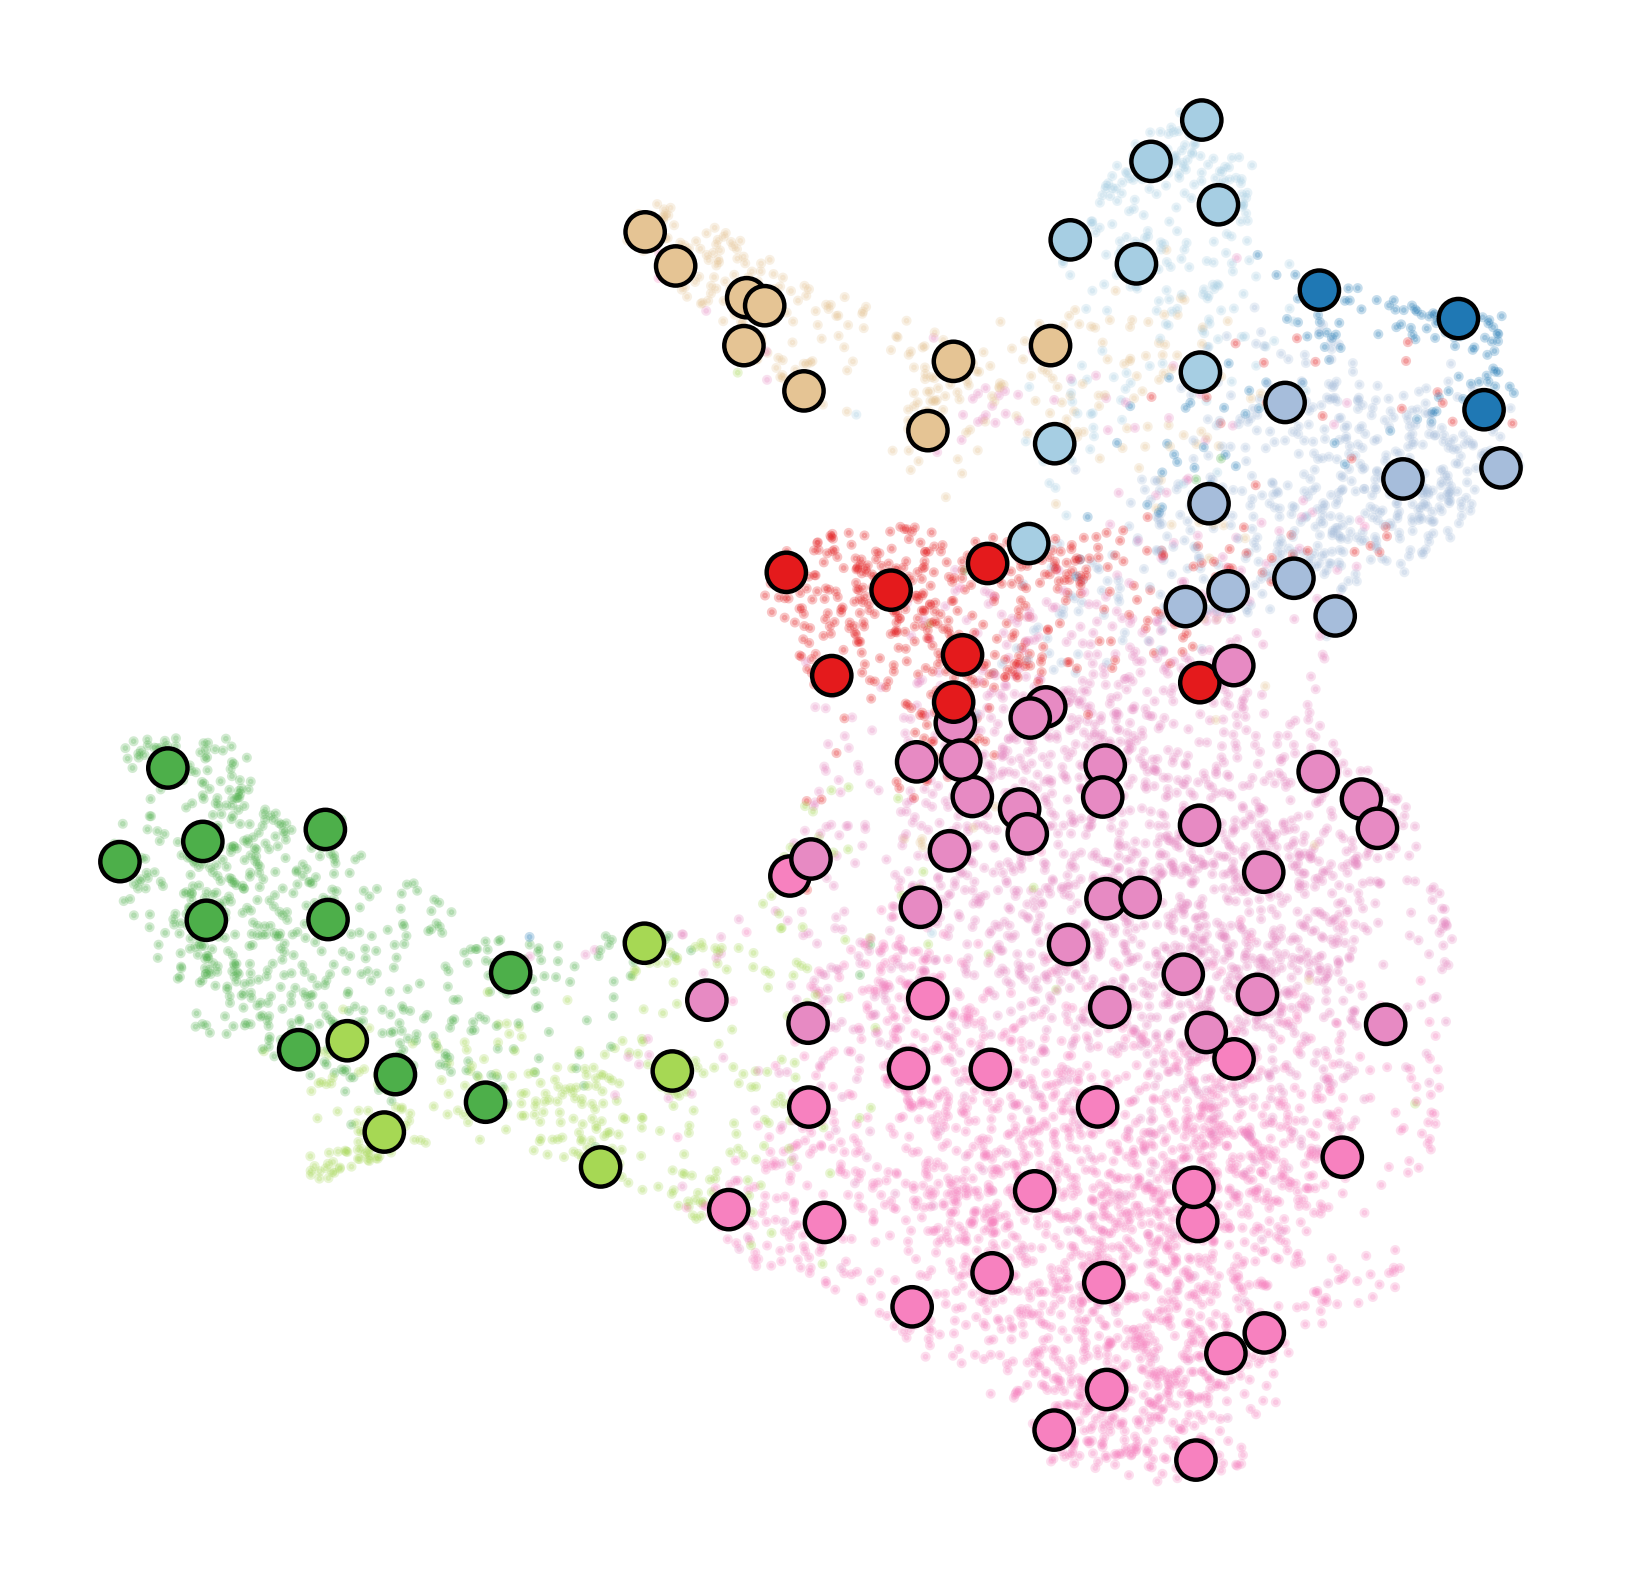

In [411]:
plt.figure(figsize=[5, 5])
ax = plt.gca()
ax.scatter(-atac_ad.obsm['X_umap'][:, 0], 
          atac_ad.obsm['X_umap'][:, 1], alpha=0.25,
          s=1, color=ct_colors[atac_ad.obs['celltype']])

atac_meta = atac_ad.obs['Metacell'].astype(str).unique()
ax.scatter(-atac_ad[atac_meta].obsm['X_umap'][:, 0], 
          atac_ad[atac_meta].obsm['X_umap'][:, 1], alpha=1,
          s=50, color=ct_colors[meta.obs.loc[atac_meta,'celltype']], 
          edgecolors='black')


ax.set_axis_off()
plt.savefig(plot_prefix + f'cd34_atac_seacell_results.png', dpi=200, bbox_inches='tight')

In [412]:
meta.obs['celltype'].value_counts()

HMP      29
HSC      21
Ery      10
CLP       9
DCPre     8
pDC       8
Mono      7
MEP       5
cDC       3
Name: celltype, dtype: int64

In [413]:
pd.Series(celltypes).value_counts()

HMP      28
Ery      15
HSC      13
CLP      10
pDC       9
DCPre     8
MEP       7
cDC       5
Mono      5
dtype: int64

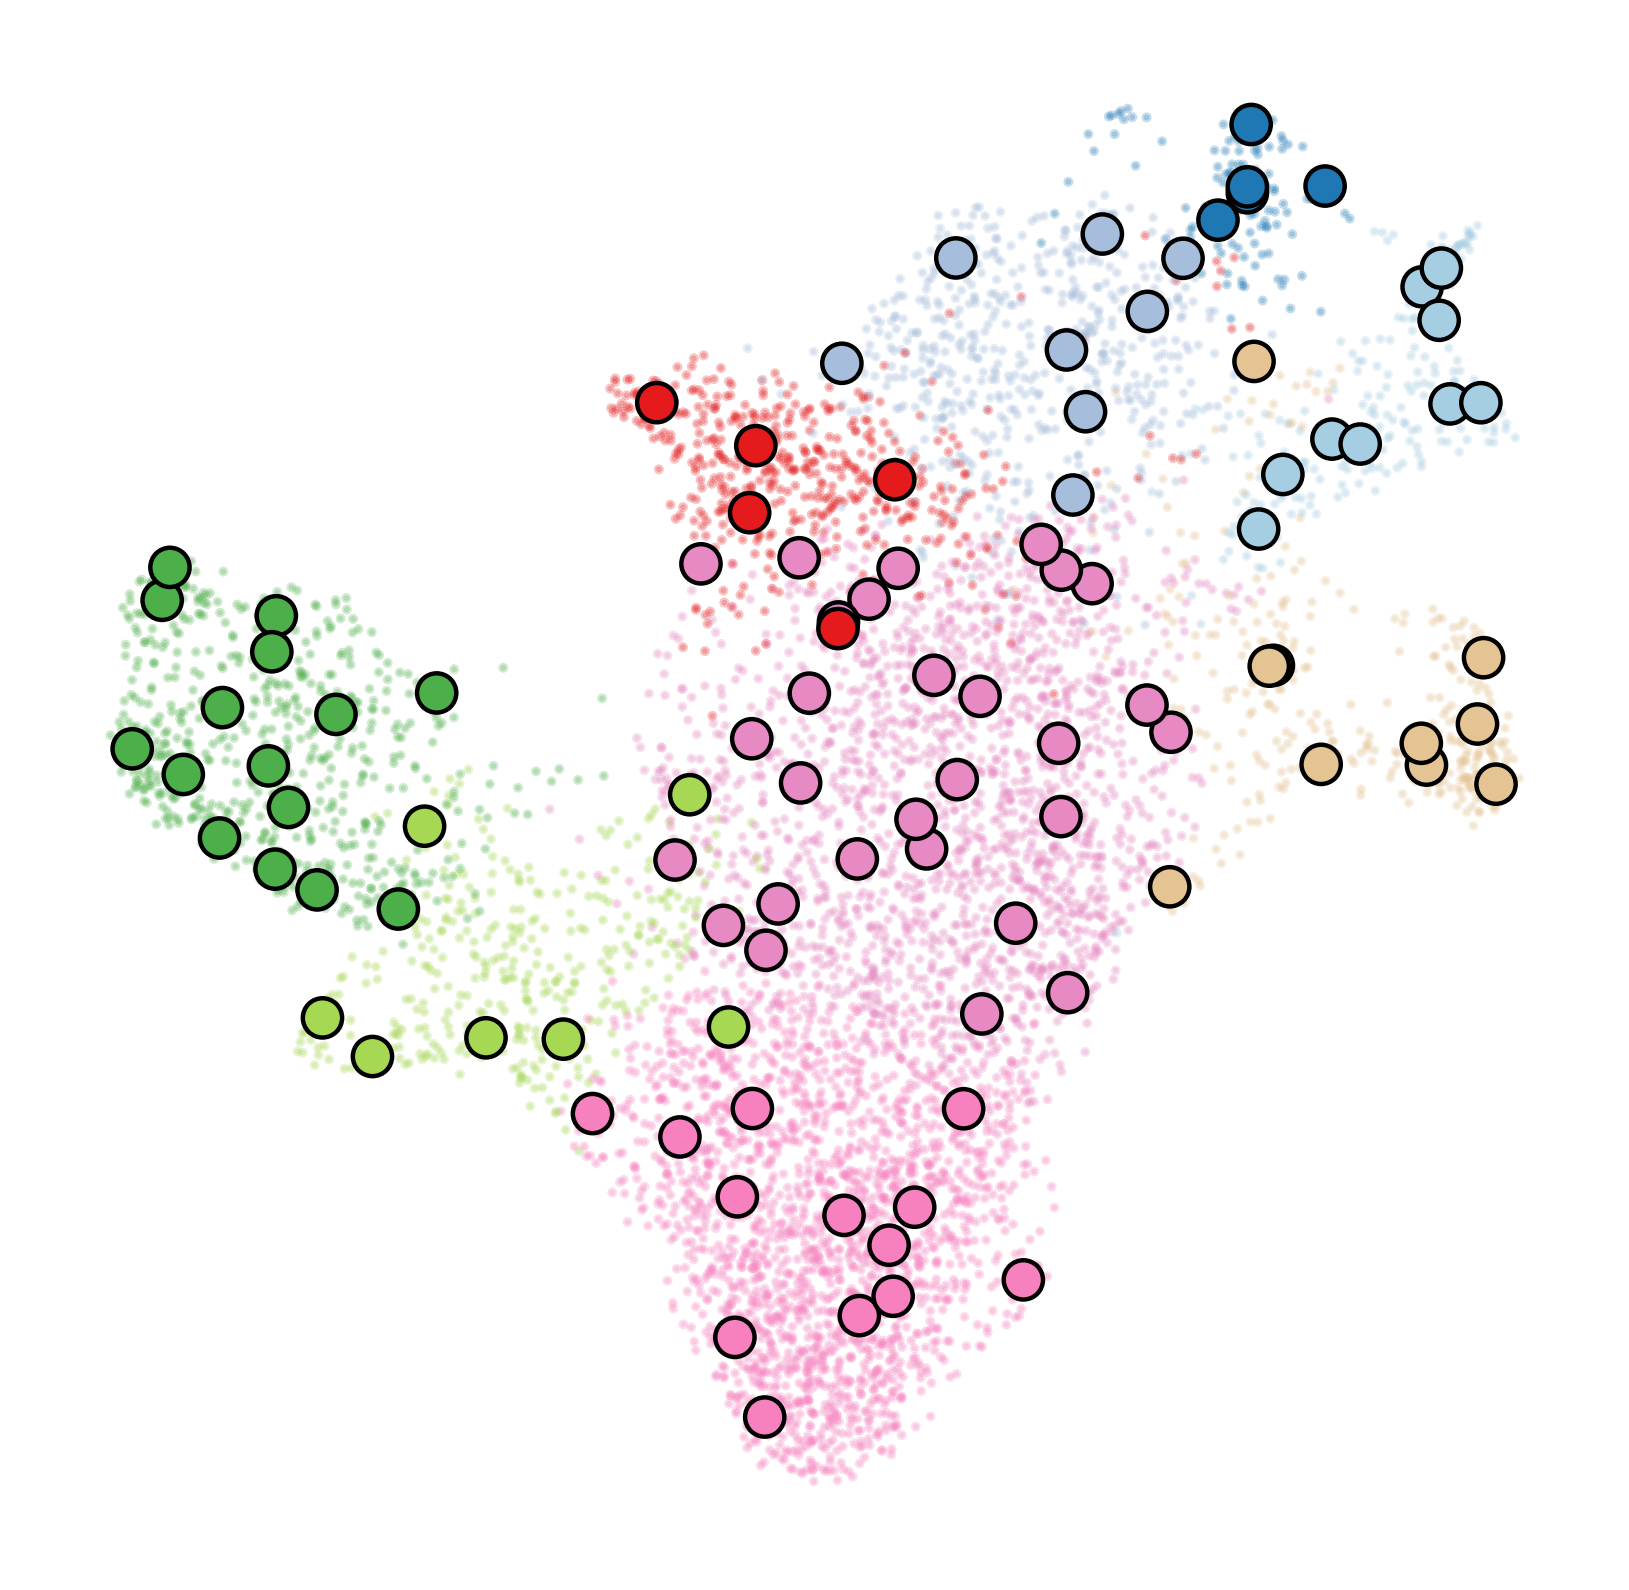

In [414]:
plt.figure(figsize=[5, 5])
ax = plt.gca()
ax.scatter(rna_ad.obsm['X_umap'][:, 0], 
          rna_ad.obsm['X_umap'][:, 1], alpha=0.25,
          s=1, color=ct_colors[rna_ad.obs['celltype']])

rna_meta = rna_ad.obs['Metacell'].astype(str).unique()
celltypes = [rna_ad[rna_ad.obs['Metacell'] == mc].obs['celltype'].value_counts().index[0] for mc in rna_meta]

ax.scatter(rna_ad[rna_meta].obsm['X_umap'][:, 0], 
          rna_ad[rna_meta].obsm['X_umap'][:, 1], alpha=1,
          s=50, color=ct_colors[celltypes], 
          edgecolors='black')


ax.set_axis_off()
plt.savefig(plot_prefix + f'cd34_rna_seacell_results.png', dpi=200, bbox_inches='tight')

## TFIDF

In [415]:
# from sklearn.feature_extraction.text import TfidfTransformer

# mat = (atac_ad.X).astype(int)
# tfidf = TfidfTransformer().fit(mat)
# atac_ad.layers['TFIDF'] = tfidf.transform(mat)

In [416]:
# 6881 / 75

## ATAC Meta cell 

In [417]:
atac_meta_ad = sc.read(data_dir + 'atac_meta_ad.h5ad')

In [418]:
atac_meta_ad.X.mean()

4.251235

In [419]:
gs = pd.DataFrame(atac_ad.obsm['GeneScores'], 
            index=atac_ad.obs_names, columns=atac_ad.uns['GeneScoresColums'])

In [420]:
gs_aggr = gs.groupby(atac_ad.obs['Metacell']).sum().loc[metacells]

In [421]:
atac_meta_ad.obsm['GeneScores'] = gs_aggr.loc[atac_meta_ad.obs_names, :]
atac_meta_ad.uns['GeneScoresColumns'] = gs_aggr.columns

## RNA meta cell

In [422]:
#read in previous

In [423]:
rna_meta_ad = sc.read(data_dir + 'rna_meta_ad.h5ad')

In [424]:
# this was our reaggregated rna meta cell anndata, its practically the same,
# I am just going to transfer over some of the annotations/umap
meta

AnnData object with n_obs × n_vars = 100 × 12464
    obs: 'celltype', 'palantir_pseudotime', 'n_counts'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [425]:
rna_meta_ad

AnnData object with n_obs × n_vars = 100 × 12464
    obs: 'celltype', 'phenograph', 'n_counts'
    var: 'highly_variable'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [426]:
rna_meta_ad.X.mean()

52.37236

In [427]:
meta.X.mean()

52.37242

## copy annotations

In [428]:
rna_meta_ad.obsm['X_umap'] = meta[rna_meta_ad.obs_names, :].obsm['X_umap'].copy()
rna_meta_ad.obs['palantir_pseudotime'] = meta[rna_meta_ad.obs_names, :].obs['palantir_pseudotime'].copy()
rna_meta_ad.obs['celltype'] = meta[rna_meta_ad.obs_names, :].obs['celltype'].copy()
rna_meta_ad.uns['celltype_colors'] = ct_colors.loc[rna_meta_ad.obs['celltype'].cat.categories].values

# Illustration -- not run

In [36]:
eigs = pd.DataFrame(atac_ad.obsm['DM_EigenVectors'], index=atac_ad.obs_names).loc[:, 1:7]
waypoints = palantir.core._max_min_sampling(eigs, 100)

In [37]:
ct_colors = pd.Series(rna_ad.uns['celltype_colors'], 
                     index=rna_ad.obs['celltype'].values.categories)

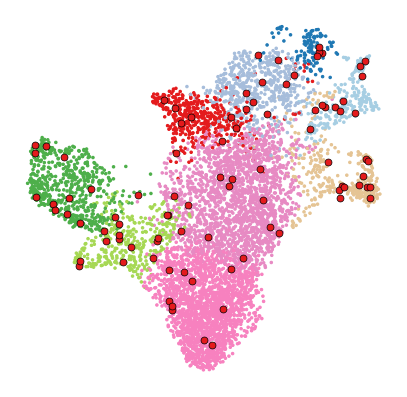

In [38]:
plt.figure(figsize=[5, 5])
umap = rna_ad.obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], s=3, 
           color=ct_colors[rna_ad.obs['celltype']])
ax = plt.gca()
ax.set_axis_off()

umap = rna_ad[waypoints].obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], s=25, 
           color='#e41a1c', edgecolor='black', linewidths=0.5)
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + 'umap_with_waypoint.png', dpi=150, bbox_inches='tight')

In [39]:
nrow, ncol = 10, 3
df = (pd.DataFrame(0, index=np.arange(nrow), columns=np.arange(ncol)))
for i in df.index:
    val = np.random.uniform(0.8, 1, 1)
    col = np.random.choice([0, 1, 2], 1)
    
    other = 1 - val
    second_val = np.random.uniform(0, other, 1)
    second_col = np.random.choice(pd.Index([0, 1, 2]).difference(col), 1)
    
    df.loc[i, col] = val
    df.loc[i, second_col] = second_val 
    df.loc[i, pd.Index([0, 1, 2]).difference([col[0], second_col[0]])] = 1 - val - second_val
df.index = np.repeat("", nrow)
df.columns = np.repeat("", ncol)

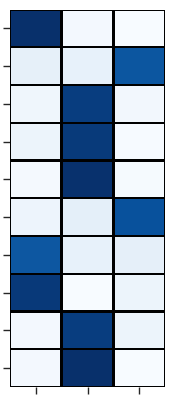

In [40]:
plt.figure(figsize=[2, 5])
sns.heatmap(df, cmap=matplotlib.cm.Blues, 
            linecolor='black', linewidth=1, cbar=False, )
plt.savefig(plot_prefix + 'seacells_b.png', dpi=150, bbox_inches='tight')

In [41]:
nrow, ncol = 10, 3
df = (pd.DataFrame(0, index=np.arange(nrow), columns=np.arange(ncol)))
for i in df.index:
    val = np.random.uniform(0.8, 1, 1)
    col = np.random.choice([0, 1, 2], 1)
    
    other = 1 - val
    second_val = np.random.uniform(0, other, 1)
    second_col = np.random.choice(pd.Index([0, 1, 2]).difference(col), 1)
    
    df.loc[i, col] = val
    df.loc[i, second_col] = second_val 
    df.loc[i, pd.Index([0, 1, 2]).difference([col[0], second_col[0]])] = 1 - val - second_val
df.index = np.repeat("", nrow)
df.columns = np.repeat("", ncol)

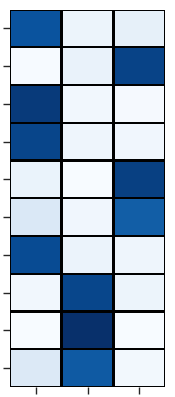

In [42]:
plt.figure(figsize=[2, 5])
sns.heatmap(df, cmap=matplotlib.cm.Blues, 
            linecolor='black', linewidth=1, cbar=False, )
plt.savefig(plot_prefix + 'seacells_a.png', dpi=150, bbox_inches='tight')

## Kernel

In [43]:
kernel = pd.DataFrame(atac_ad.obsp['DM_kernel'].todense(), 
                     index=atac_ad.obs_names, columns=atac_ad.obs_names)

In [44]:
purity = pd.Series(0.0, index=rna_meta_ad.obs_names)
for m in rna_meta_ad.obs_names:
    cells = atac_ad.obs_names[atac_ad.obs['Metacell'] == m]
    f = rna_ad.obs['celltype'][cells].value_counts()
    f = f/np.sum(f)
    purity[m] = f.max()

In [45]:
(purity > 0.99).sum()

19

In [46]:
# use_meta = np.random.choice(rna_meta_ad.obs_names, 25, False)
use_meta = purity.index[purity > 0.95]
# meta = np.unique(rna_ad.obs['Metacell'][use_cells].astype(str))
use_cells = rna_ad.obs_names[atac_ad.obs['Metacell'].isin(use_meta)]
len(use_cells)

use_cells = np.random.choice(use_cells, 1000, False)

In [47]:
eigs = pd.DataFrame(atac_ad.obsm['DM_EigenVectors'], index=atac_ad.obs_names).loc[use_cells, :]
waypoints = palantir.core._max_min_sampling(eigs, 100)

## Single-cell heatmap

In [48]:
vmax = 0.35

In [49]:
ct_order = ['HSC', 'HMP', 'Ery', 'MEP', 'Mono', 'cDC', 'pDC', 'DCPre',   'CLP']
cell_order = pd.Series(dtype=object)
for ct in ct_order:
    cells = use_cells[rna_ad.obs['celltype'][use_cells] == ct]
    cells = rna_ad.obs['palantir_pseudotime'][cells].sort_values().index
    cell_order = cell_order.append(cells.to_series())

In [50]:
len(cell_order)

1000

In [51]:
eigs = pd.DataFrame(atac_ad.obsm['DM_EigenVectors'], index=atac_ad.obs_names).loc[use_cells, :]
waypoints = palantir.core._max_min_sampling(eigs, 100)

In [52]:
labels2 = pd.Series(0, index=use_cells)
labels2[waypoints] = 1
lut2 = {0:'#ffffff', 1:'#e41a1c'}
row_colors2 = pd.DataFrame(labels2)[0].map(lut2)


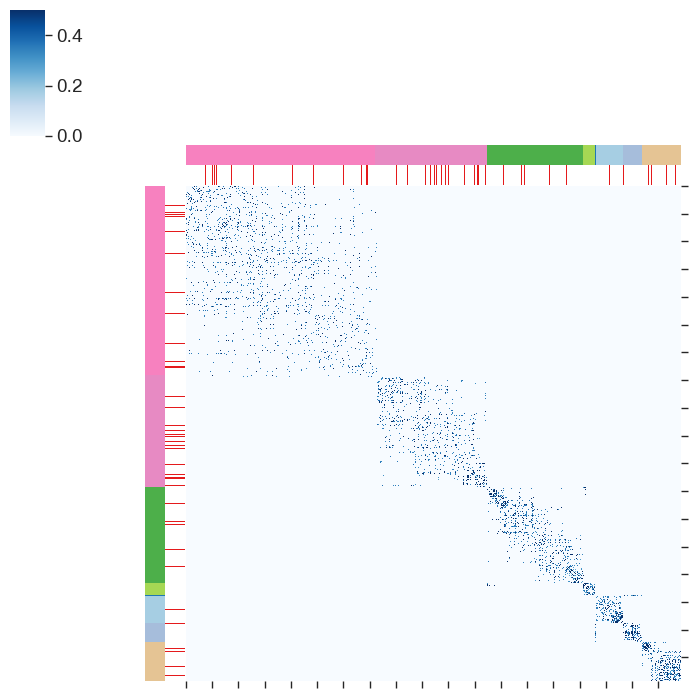

In [53]:
colors = ct_colors[rna_ad.obs['celltype'][cell_order]].values
labels = np.repeat("", len(cell_order))

plot_df = kernel.loc[cell_order, cell_order]
plot_df.index = plot_df.columns = labels

sns.clustermap(plot_df, 
               cmap=matplotlib.cm.Blues, vmax=0.5, 
               row_cluster=False, col_cluster=False,
               row_colors=[colors, row_colors2], col_colors=[colors, row_colors2], 
              figsize=[7, 7])
plt.savefig(plot_prefix + 'heatmap_singlecell.png', dpi=150, bbox_inches='tight')

## SEACells

In [54]:
cell_order = pd.Series(dtype=object)

for ct in ct_order:
    meta = use_meta[rna_ad.obs['celltype'][use_meta] == ct]
    for m in rna_ad.obs['palantir_pseudotime'][meta].sort_values().index:
        cells = atac_ad.obs_names[atac_ad.obs['Metacell'] == m].intersection(use_cells)
        cells = rna_ad.obs['palantir_pseudotime'][cells].sort_values().index
        cell_order = cell_order.append(cells.to_series())

In [55]:
len(cell_order)

1000

In [56]:
labels2 = pd.Categorical(atac_ad.obs['Metacell'][cell_order].values).codes
lut2 = dict(zip(set(labels2), sns.color_palette('Set2', len(set(labels2)))))
row_colors2 = pd.DataFrame(labels2)[0].map(lut2)


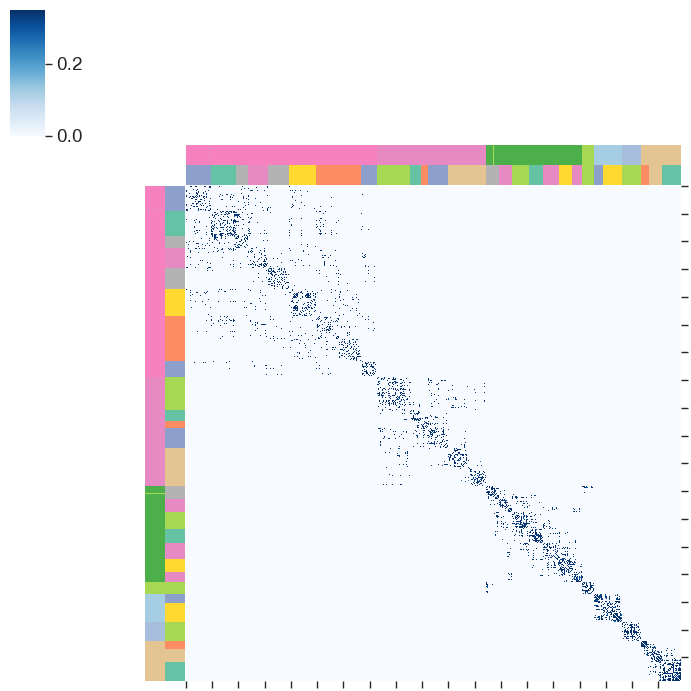

In [57]:
colors = ct_colors[rna_ad.obs['celltype'][cell_order]].values
labels = np.repeat("", len(cell_order))

plot_df = kernel.loc[cell_order, cell_order]
plot_df.index = plot_df.columns = labels

sns.clustermap(plot_df, 
               cmap=matplotlib.cm.Blues, vmax=vmax, 
               row_cluster=False, col_cluster=False,
               row_colors=[colors, row_colors2], col_colors=[colors, row_colors2], 
              figsize=[7, 7])
plt.savefig(plot_prefix + 'heatmap_seacell.png', dpi=150, bbox_inches='tight')

# SEACell -vs- singlecell Palantir

In [429]:
#out_dir = '/home/ec2-user/projects/metacells/data/CD34/Multiome/outs/palantir_results/'

In [430]:
# August 2022:
# read in previous
#out_dir = '/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/without-b-cells/'
import pickle
with open(data_dir + 'rna_pr_res.p', 'rb') as f:
    meta_pr_res = pickle.load(f)
    

In [431]:
def plot_palantir_results(pr_res, tsne, s=5):
    """ Plot Palantir results on tSNE
    """

    # Set up figure
    n_branches = pr_res.branch_probs.shape[1]
    n_cols = 6
    n_rows = int(np.ceil(n_branches / n_cols))
    fig = plt.figure(figsize=[2 * n_cols, 2 * (n_rows + 2)])
    gs = plt.GridSpec(
        n_rows + 2, n_cols, height_ratios=np.append([0.75, 0.75], np.repeat(1, n_rows))
    )
    cmap = matplotlib.cm.plasma
    # Pseudotime
    ax = plt.subplot(gs[0:2, 1:3])
    c = pr_res.pseudotime[tsne.index]
    ax.scatter(tsne.loc[:, "x"], tsne.loc[:, "y"], s=s, cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    ax.set_title("Pseudotime")

    # Entropy
    ax = plt.subplot(gs[0:2, 3:5])
    c = pr_res.entropy[tsne.index]
    ax.scatter(tsne.loc[:, "x"], tsne.loc[:, "y"], s=s, cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    ax.set_title("Differentiation potential")

    for i, branch in enumerate(pr_res.branch_probs.columns):
        row = int(np.floor(i / n_cols))
        ax = plt.subplot(gs[row + 2, np.remainder(i, n_cols)])
        c = pr_res.branch_probs.loc[tsne.index, branch]
        ax.scatter(
            tsne.loc[:, "x"], tsne.loc[:, "y"], s=s, cmap=matplotlib.cm.plasma, c=c
        )
        normalize = matplotlib.colors.Normalize(vmin=np.min(c), vmax=np.max(c))
        cax, _ = matplotlib.colorbar.make_axes(ax)
        cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
        ax.set_axis_off()
        ax.set_title(branch, fontsize=10)


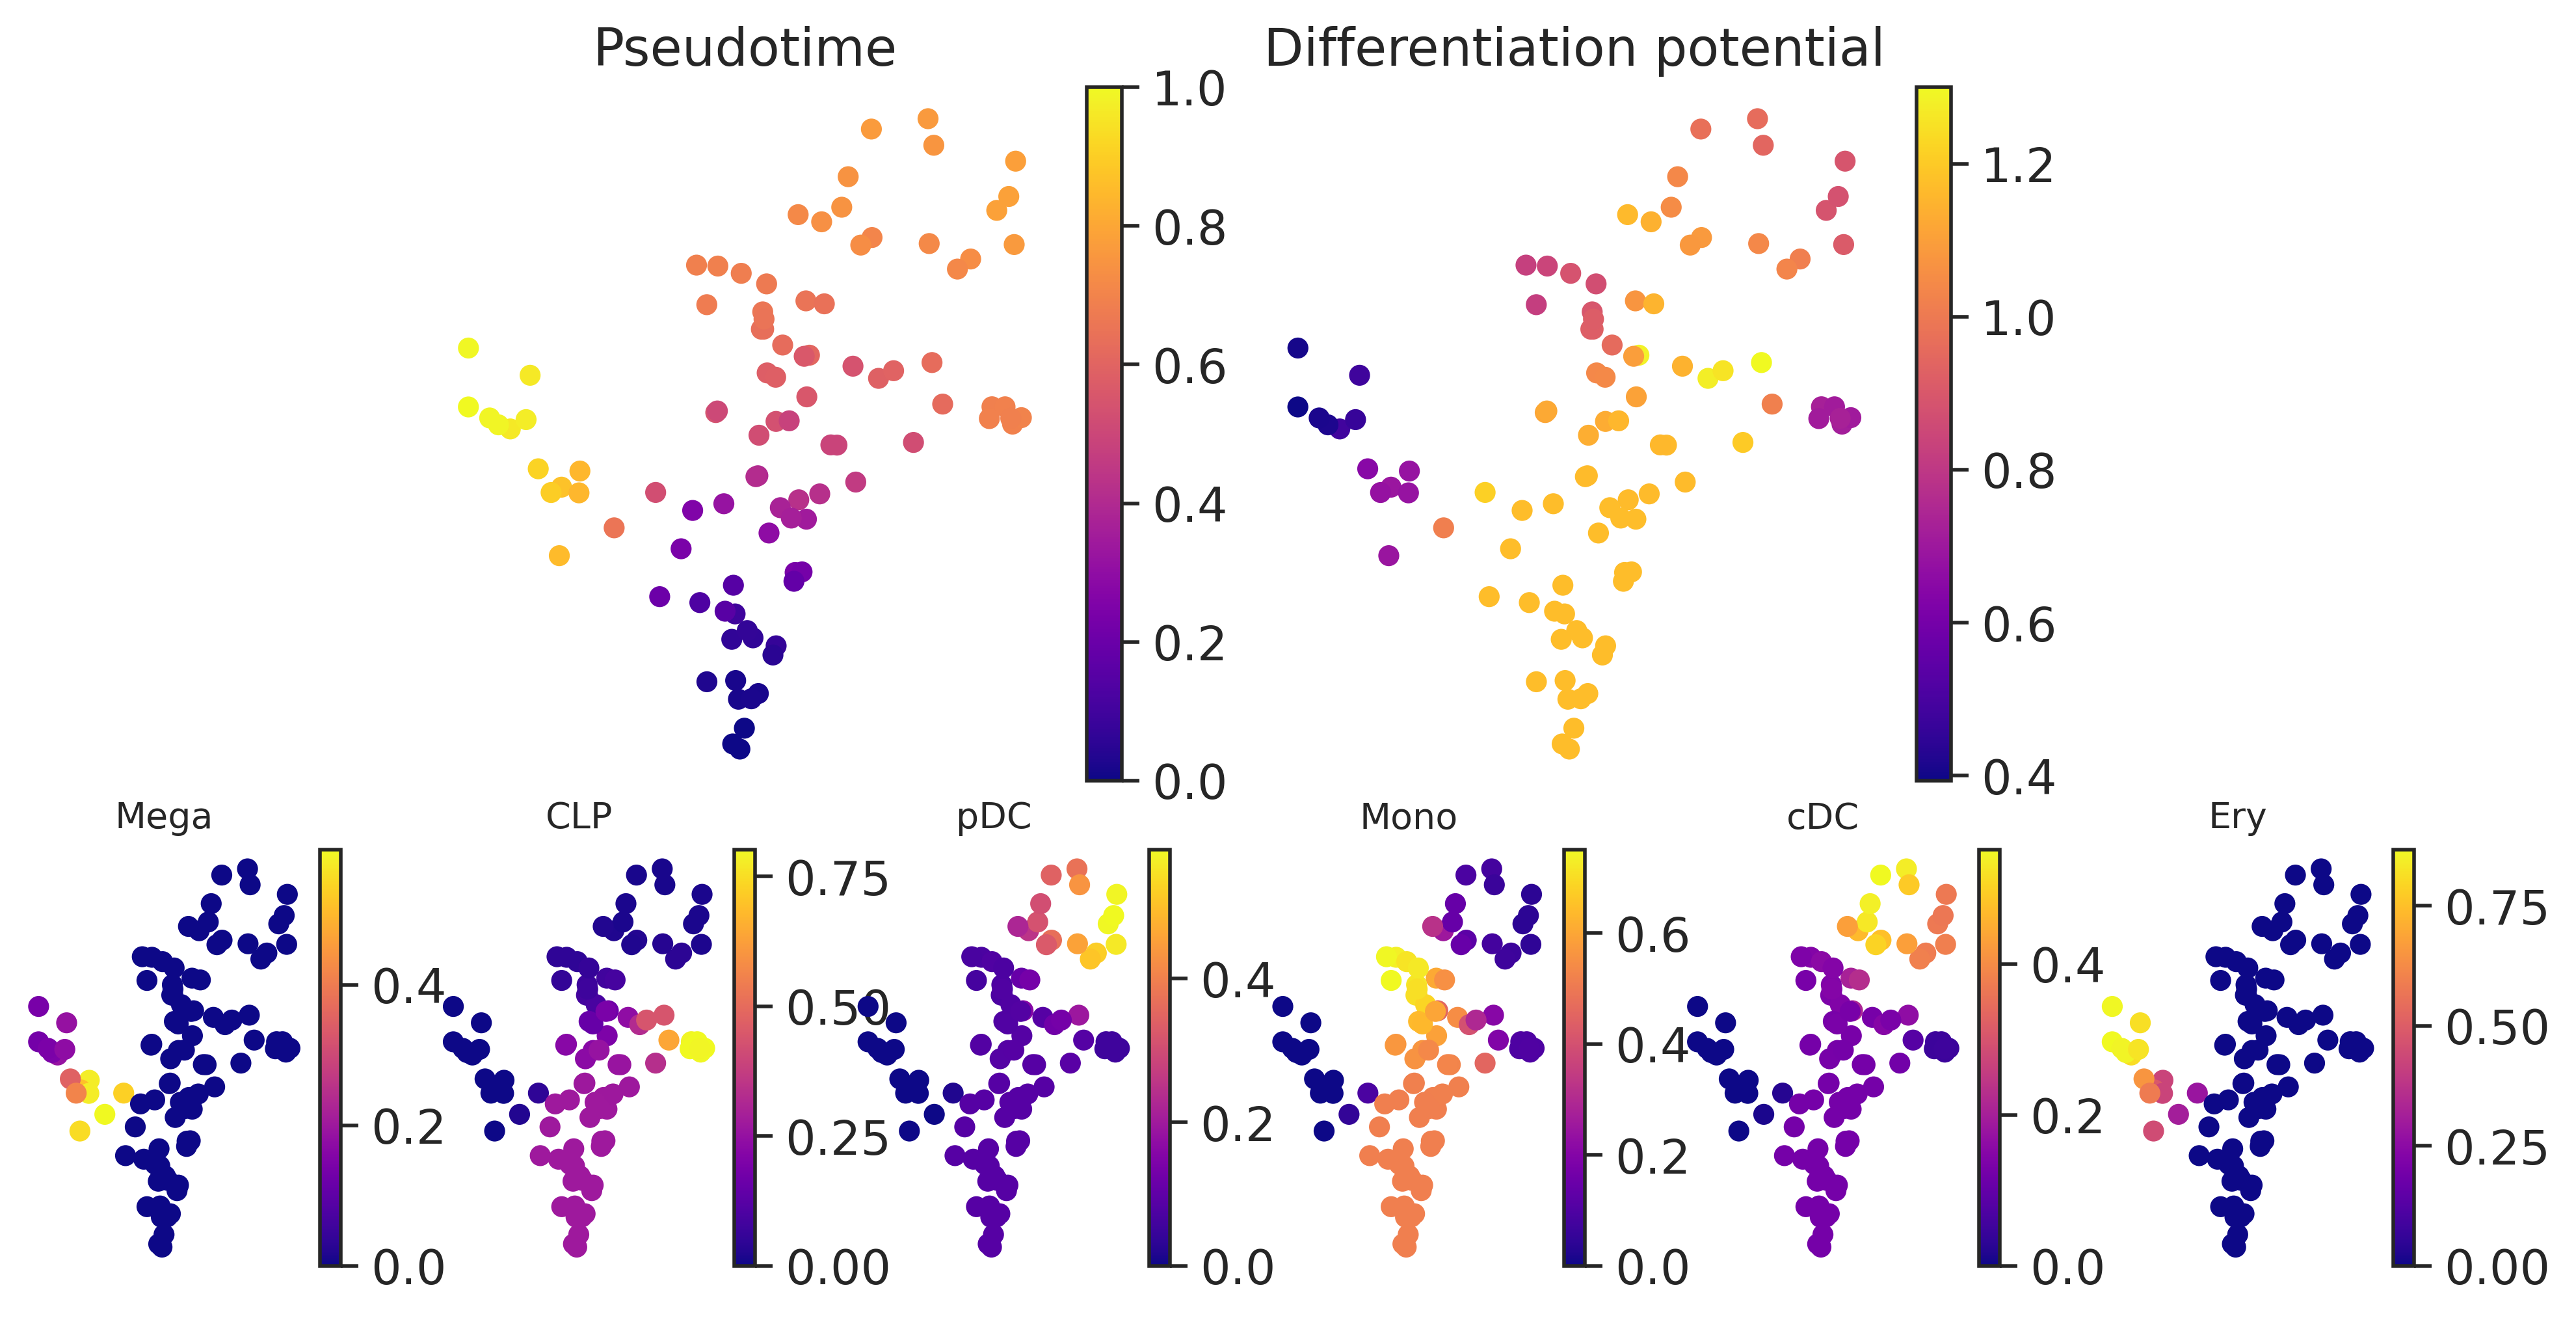

In [432]:
plot_palantir_results(meta_pr_res, 
                                   pd.DataFrame(rna_meta_ad.obsm['X_umap'], index=rna_meta_ad.obs_names,
                                               columns=['x', 'y']), s=25)
plt.savefig(plot_prefix + f'seacell_palantir_results.png', dpi=200, bbox_inches='tight')


In [433]:
# august 2022
meta_imp_df = rna_meta_ad.to_df()


# old
# Imputed data
# meta_imp_df = pd.DataFrame(rna_meta_ad.X.todense(), index=rna_meta_ad.obs_names, 
#                      columns=rna_meta_ad.var_names)
# sc_imp_df = pd.DataFrame(rna_ad.layers['MAGIC_imputed_data'], 
#                         index=rna_ad.obs_names, columns=rna_ad.var_names)


In [434]:
# Lineage cells 
meta_lineage_cells = pd.Series(dtype=object)
meta_lineage_cells['CLP'] = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype'].isin(['CLP', 'HSC', 'HMP'])]
# meta_lineage_cells['Mega'] = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype'].isin(['Mega', 'HSC'])]
meta_lineage_cells['Ery'] = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype'].isin(['MEP', 'HSC', 'Ery'])]
meta_lineage_cells['Mono'] = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype'].isin(['Mono', 'HSC', 'HMP'])]
meta_lineage_cells['cDC'] = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype'].isin(['cDC', 'DCPre',  'HSC', 'HMP'])]
meta_lineage_cells['pDC'] = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype'].isin(['pDC',  'HSC', 'HMP'])]
#meta_lineage_cells['All'] = rna_meta_ad.obs_names

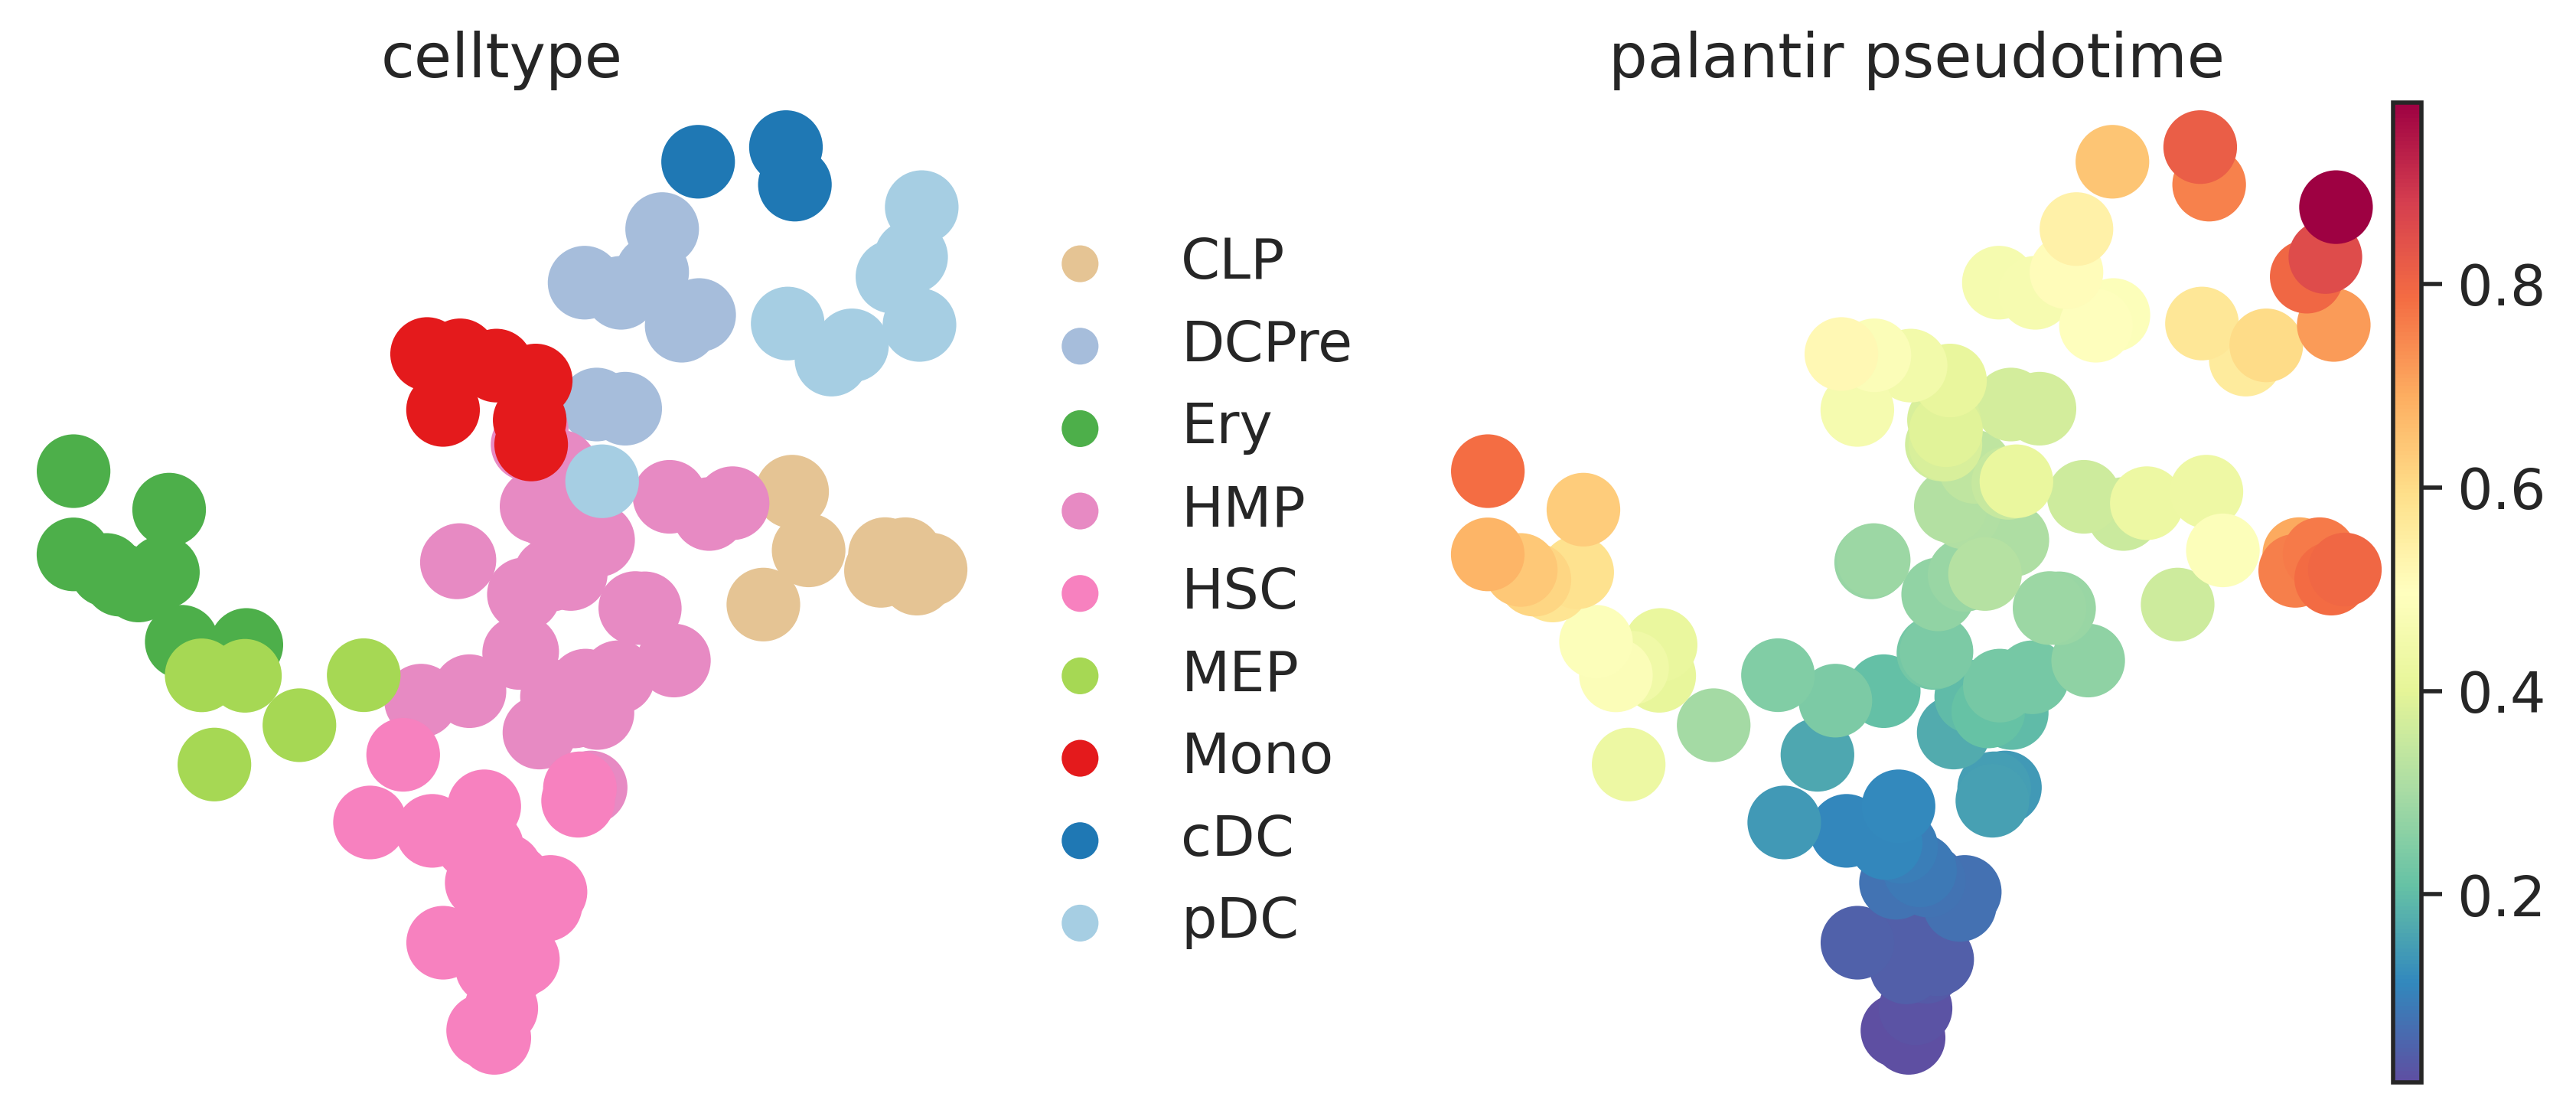

In [435]:
sc.pl.scatter(rna_meta_ad, basis='umap', color=['celltype', 'palantir_pseudotime'])


In [436]:
from pygam import LinearGAM, s
def gam_fit_predict(x, y, weights=None, pred_x=None, n_splines=4, spline_order=2):
    # Weights
    if weights is None:
        weights = np.repeat(1.0, len(x))

    # Construct dataframe
    use_inds = np.where(weights > 0)[0]

    # GAM fit
    gam = LinearGAM(s(0, n_splines=n_splines, 
                      spline_order=spline_order)).fit(x[use_inds], y[use_inds], 
                                                      weights=weights[use_inds])

    # Predict
    if pred_x is None:
        pred_x = x
    y_pred = gam.predict(pred_x)

    # Standard deviations
    p = gam.predict(x[use_inds])
    n = len(use_inds)
    sigma = np.sqrt(((y[use_inds] - p) ** 2).sum() / (n - 2))
    stds = (
        np.sqrt(1 + 1 / n + (pred_x - np.mean(x)) **
                2 / ((x - np.mean(x)) ** 2).sum())
        * sigma
        / 2
    )

    return y_pred, stds



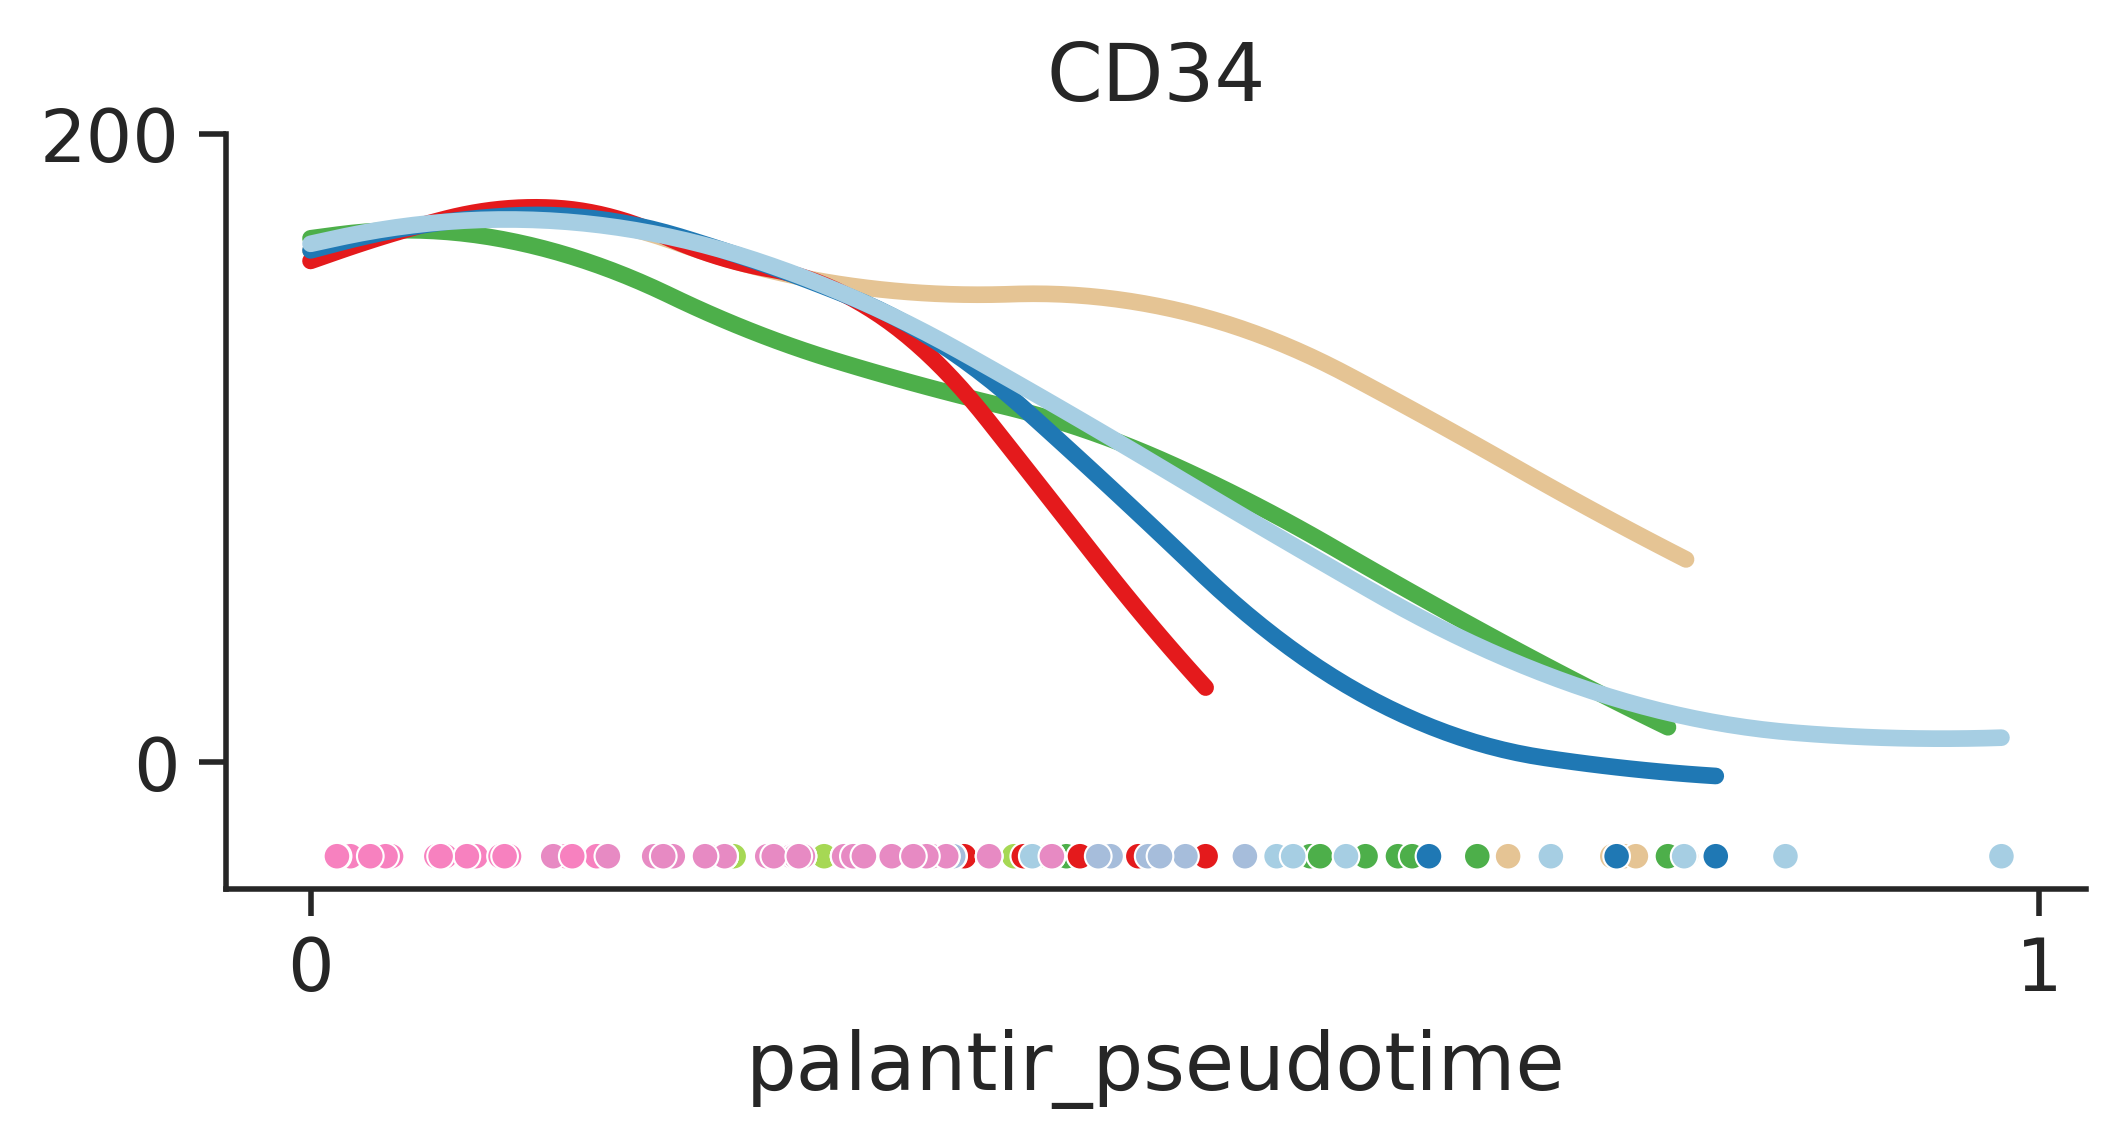

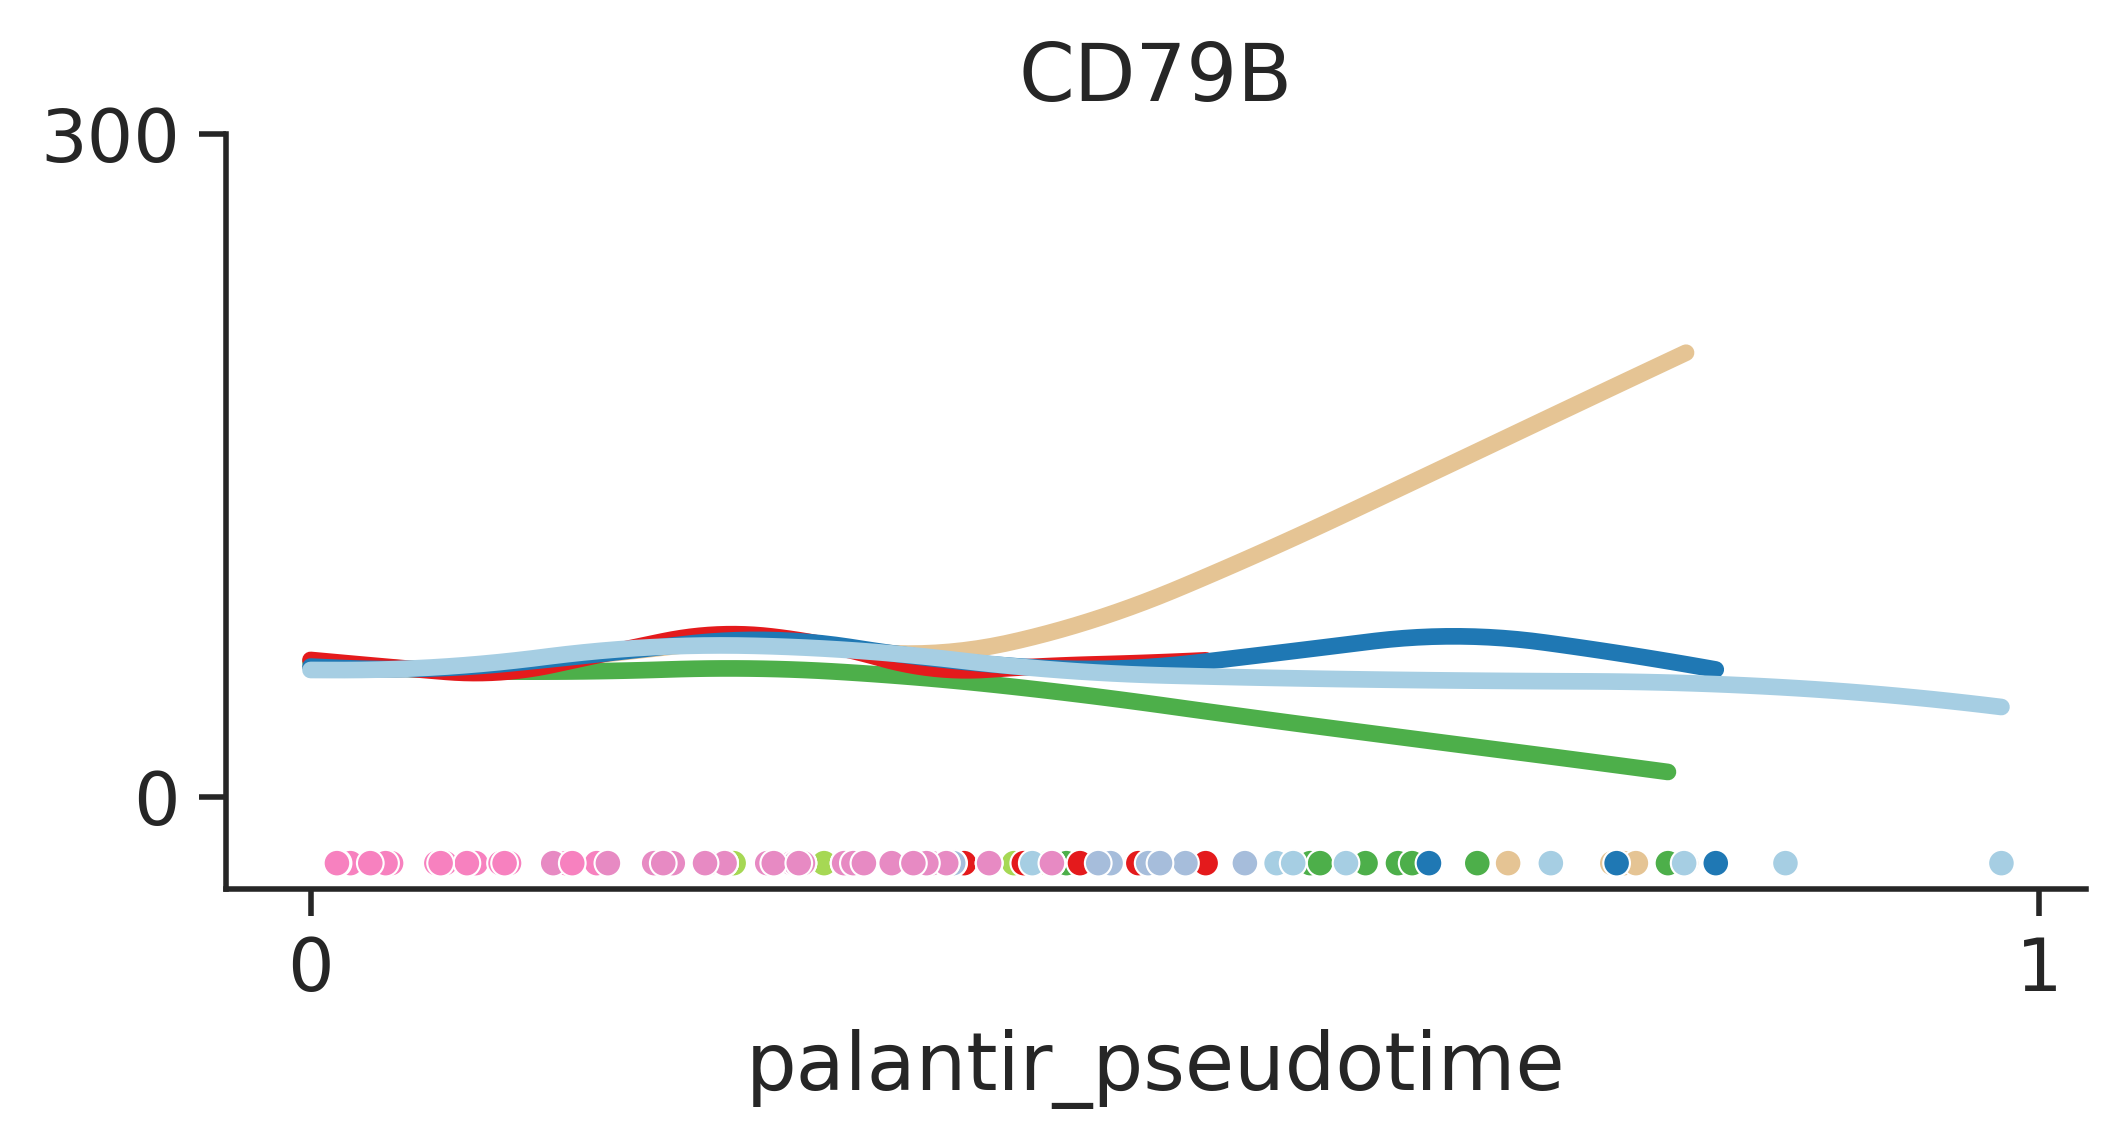

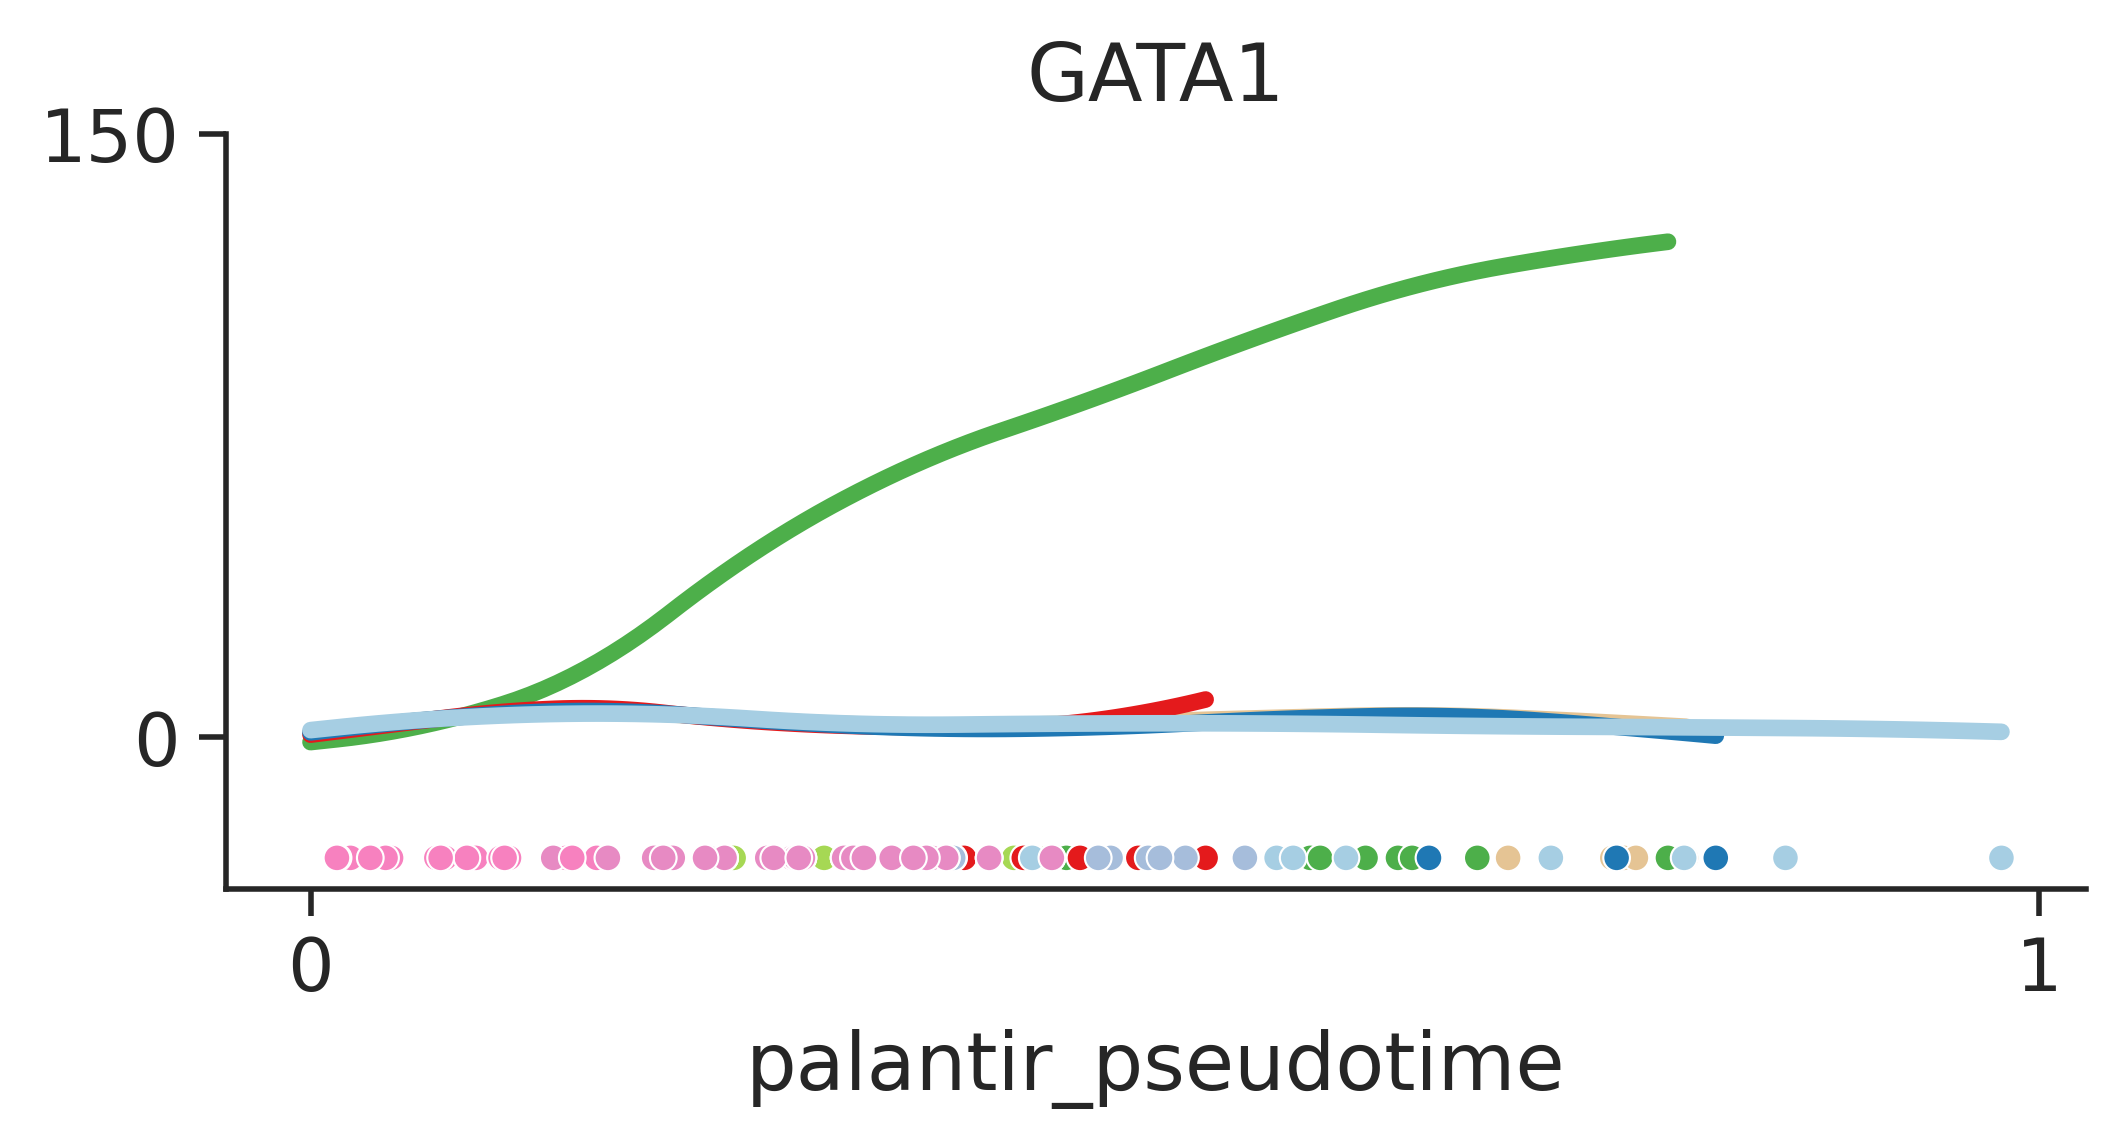

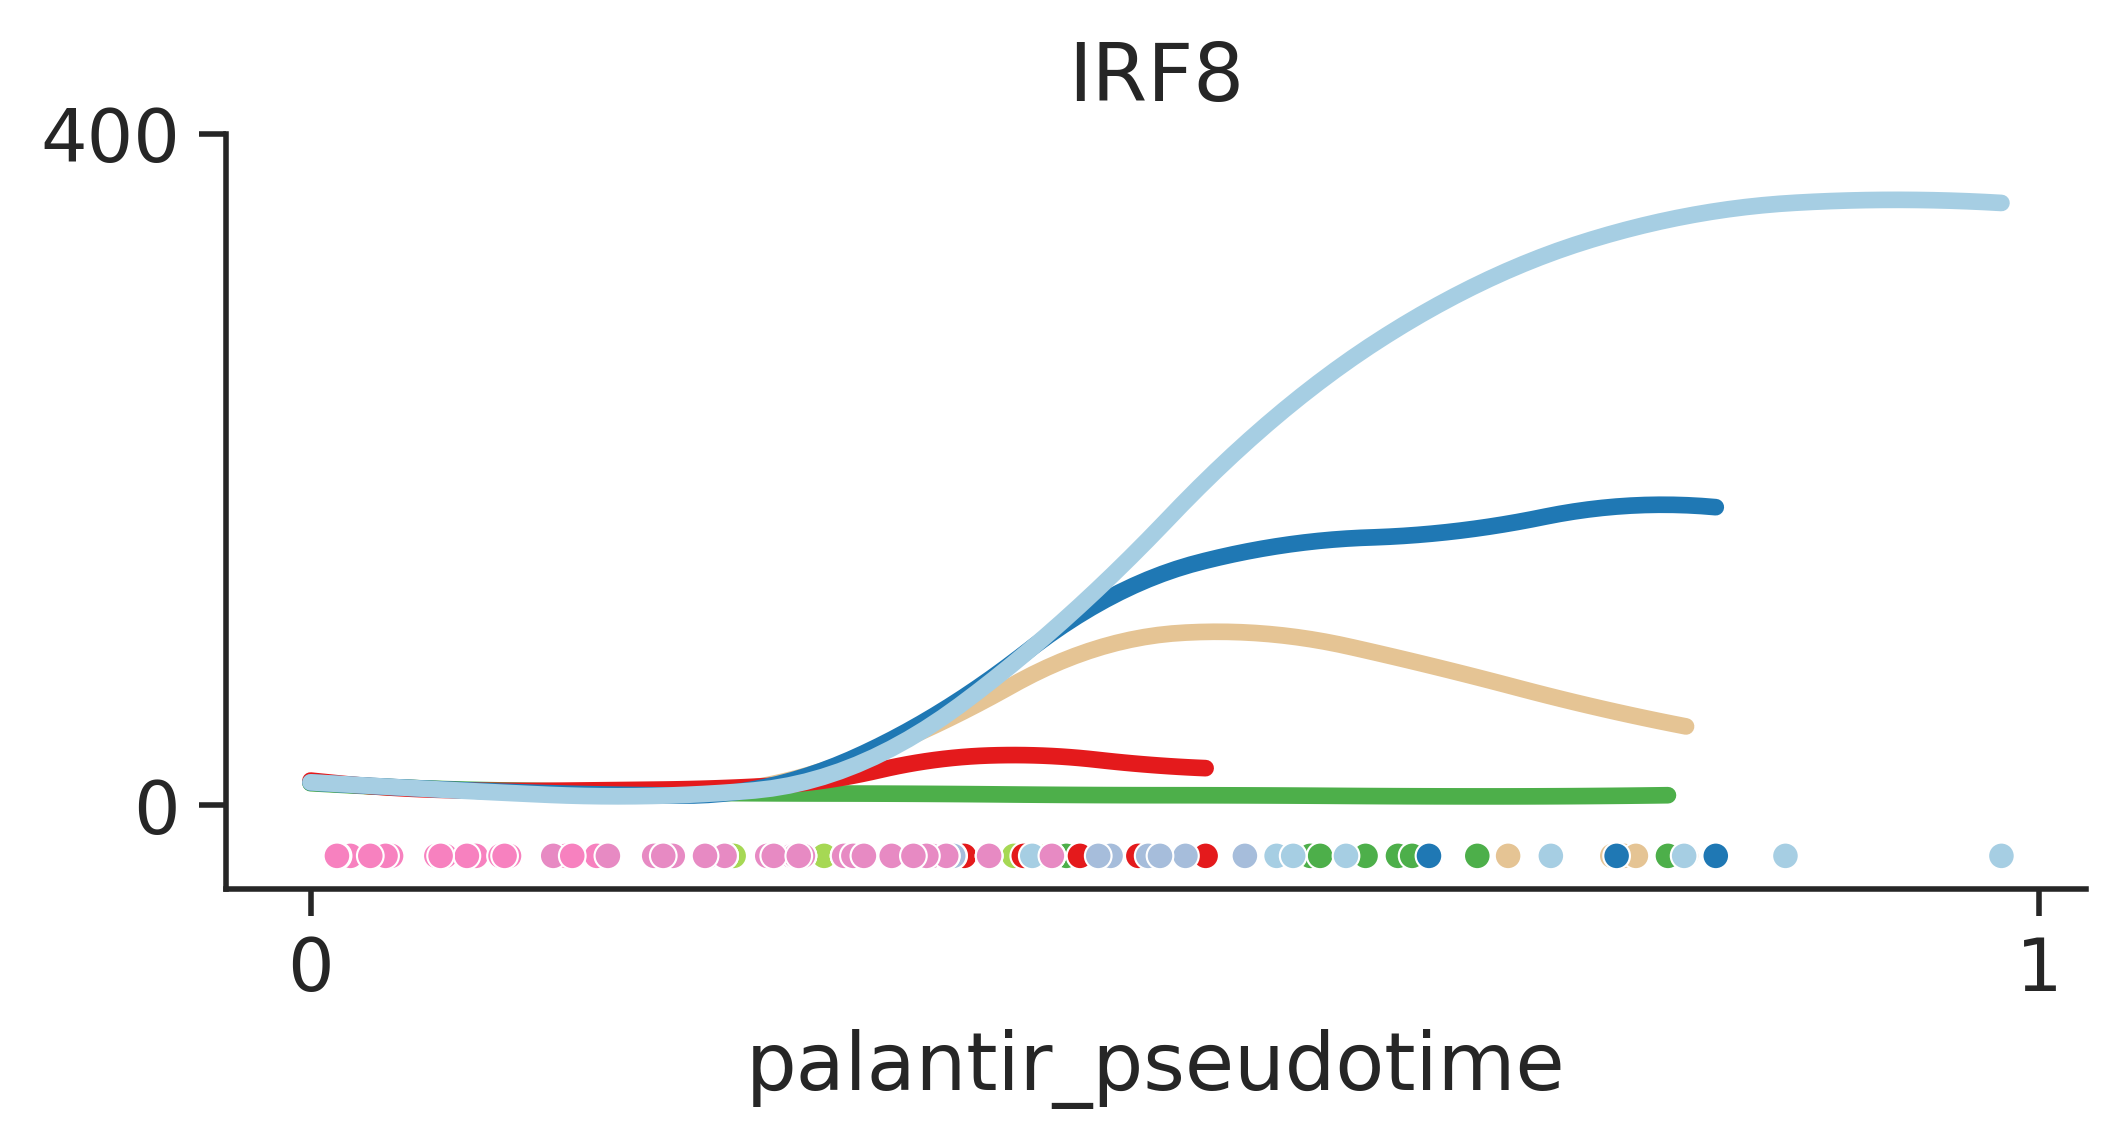

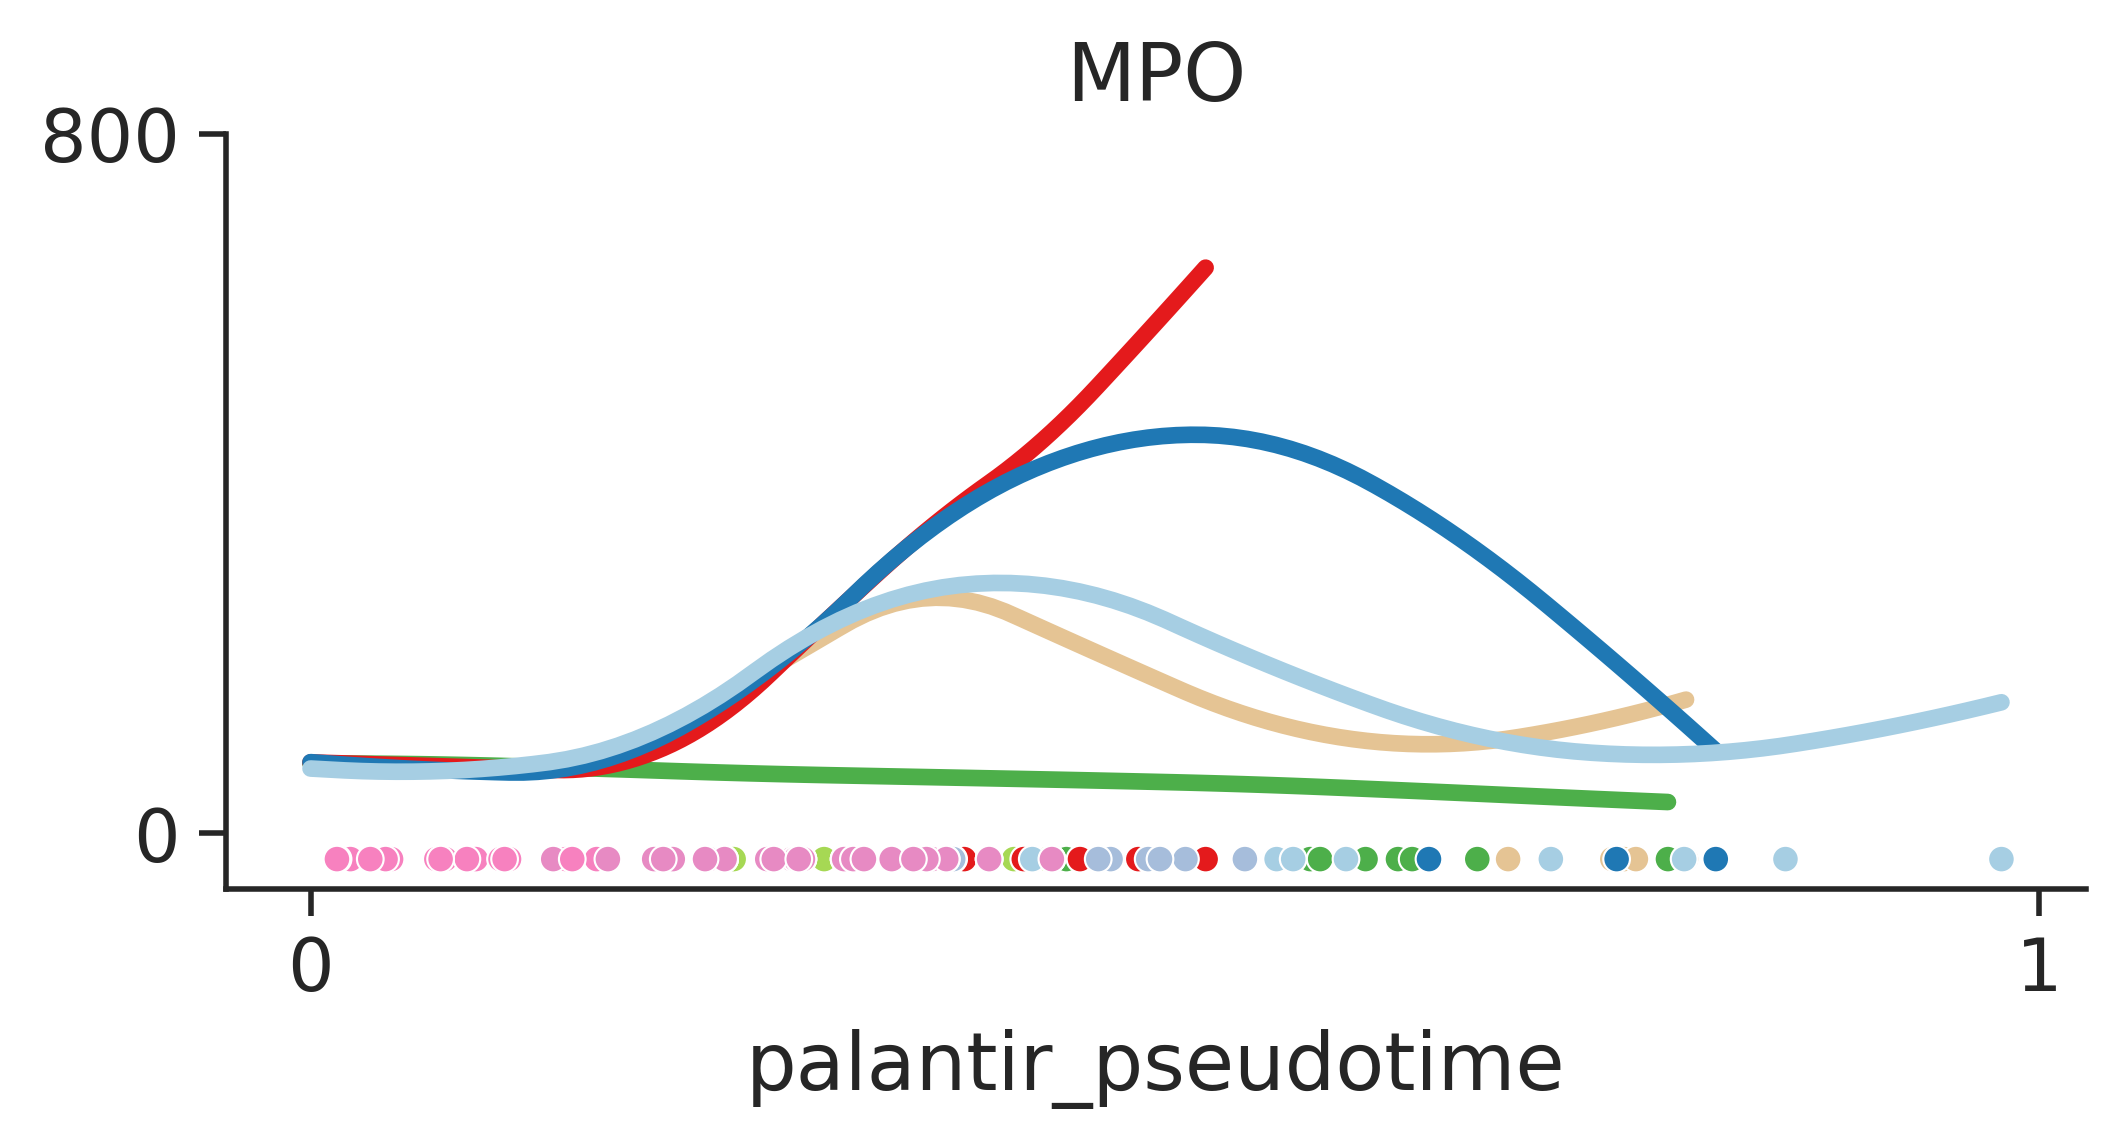

In [437]:
genes = pd.Series([
    "CD34",
    "CD79B", # CLP / B cell lineage 
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
])

figsize=[6, 2.5]
for gene in genes:
    plt.figure(figsize=figsize)
    for lineage in meta_lineage_cells.index:
        #x = meta_pr_res.pseudotime[meta_lineage_cells[lineage]]
        x = rna_meta_ad.obs.loc[meta_lineage_cells[lineage],'palantir_pseudotime']

        y = meta_imp_df.loc[x.index, gene]
        pred_x = np.linspace(0, np.max(x), 100)

        pred_y, std = gam_fit_predict(x.values, y.values,pred_x=pred_x,n_splines=10,spline_order=2)
        plt.plot(pred_x, pred_y, color=ct_colors[lineage], linewidth=3, zorder=1)
    
        # Add cells to bottom
    
        sns.scatterplot(data=rna_meta_ad.obs.loc[meta_lineage_cells[lineage]], x='palantir_pseudotime' ,
                        y=-30, hue='celltype', palette=list(rna_meta_ad.uns['celltype_colors'])
                        , legend=None)
    
    plt.title(gene)
    plt.xticks([0, 1])
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    sns.despine() 
    #plt.savefig(plot_prefix + f'{gene}_SEACell.png', dpi=150, bbox_inches='tight')
 

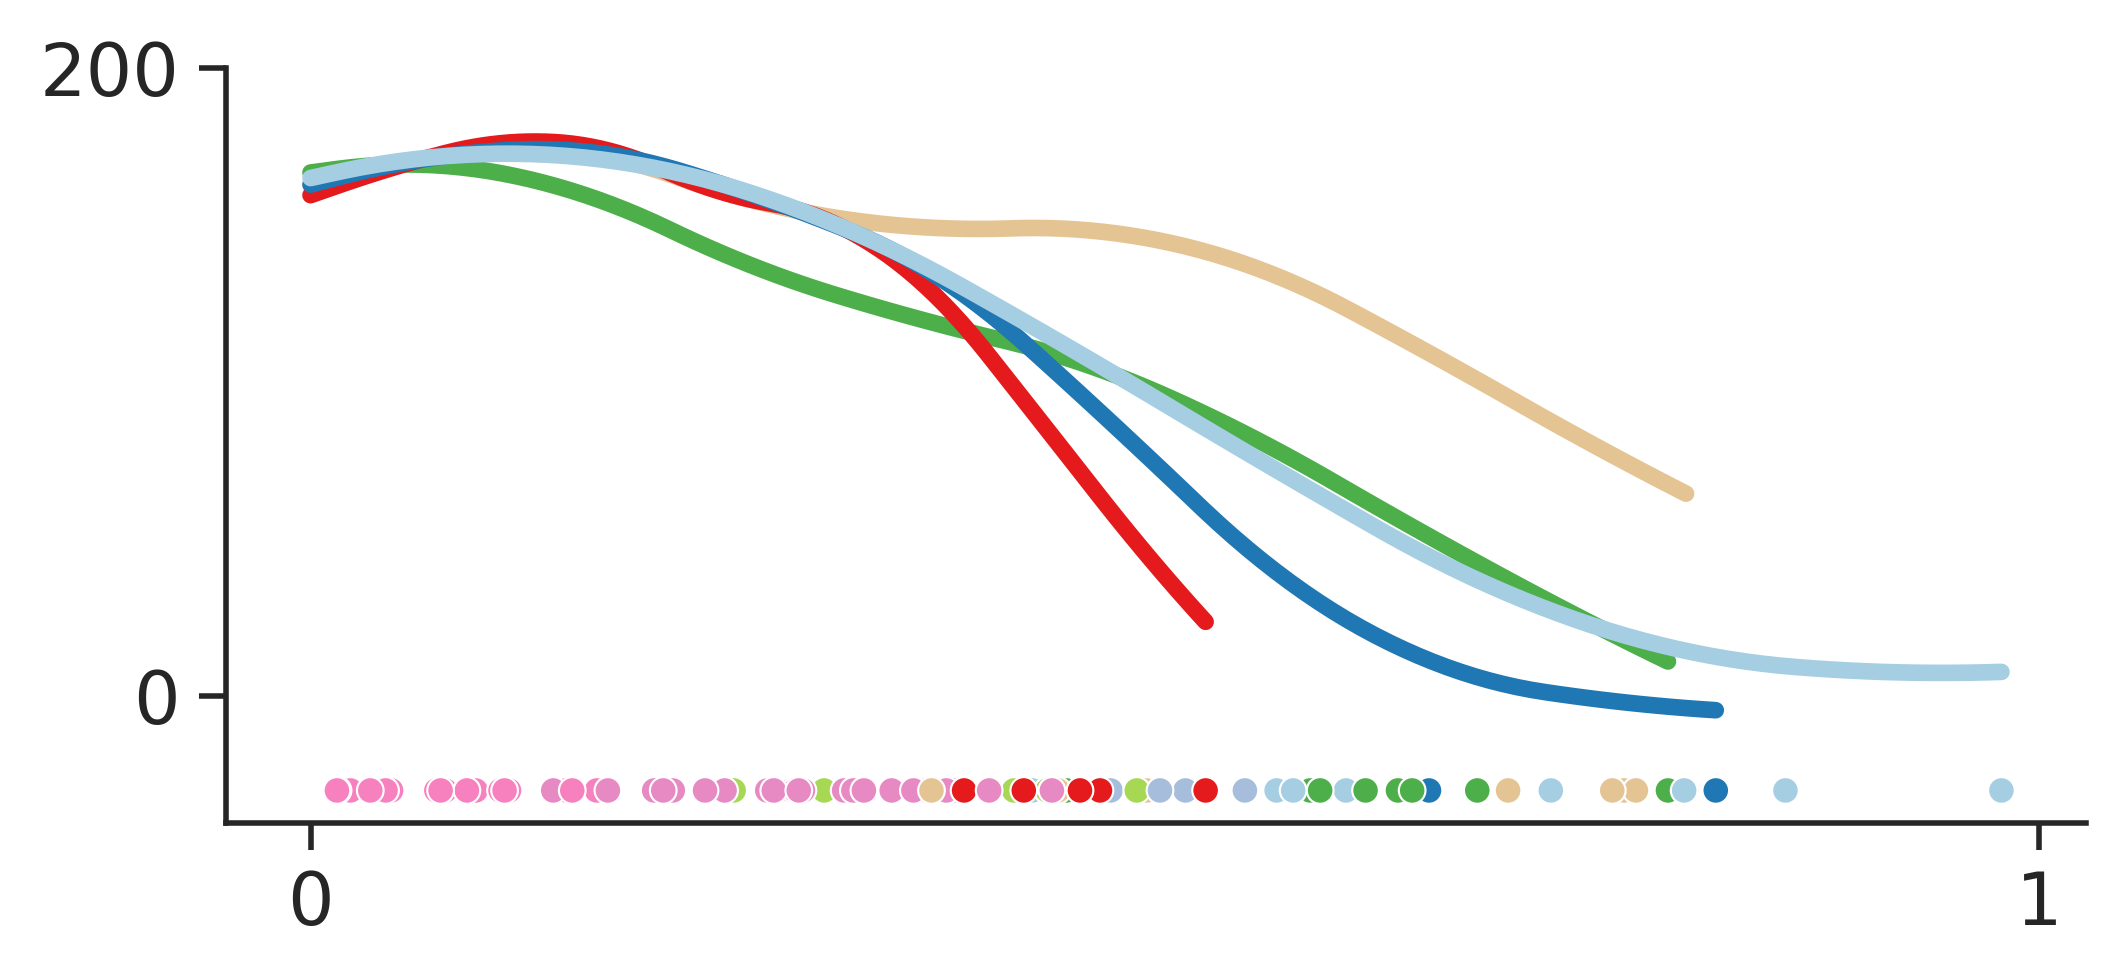

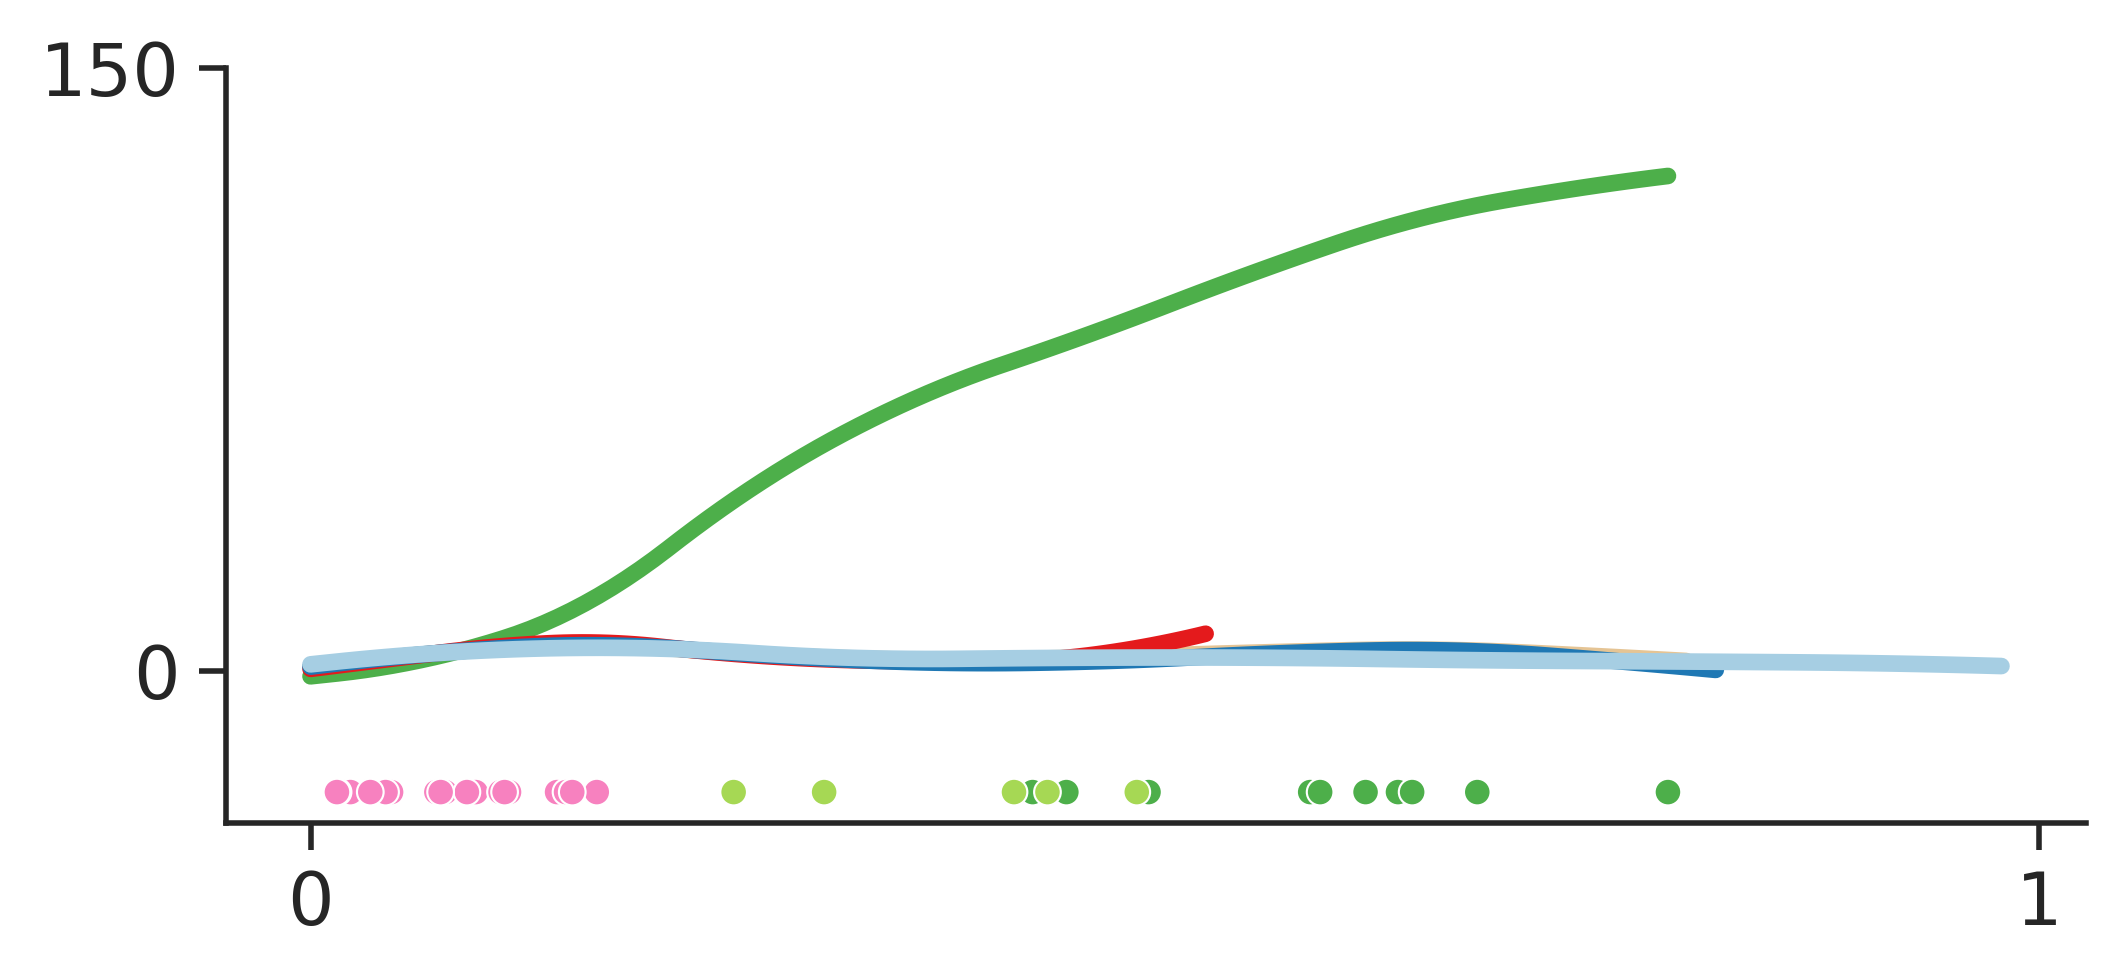

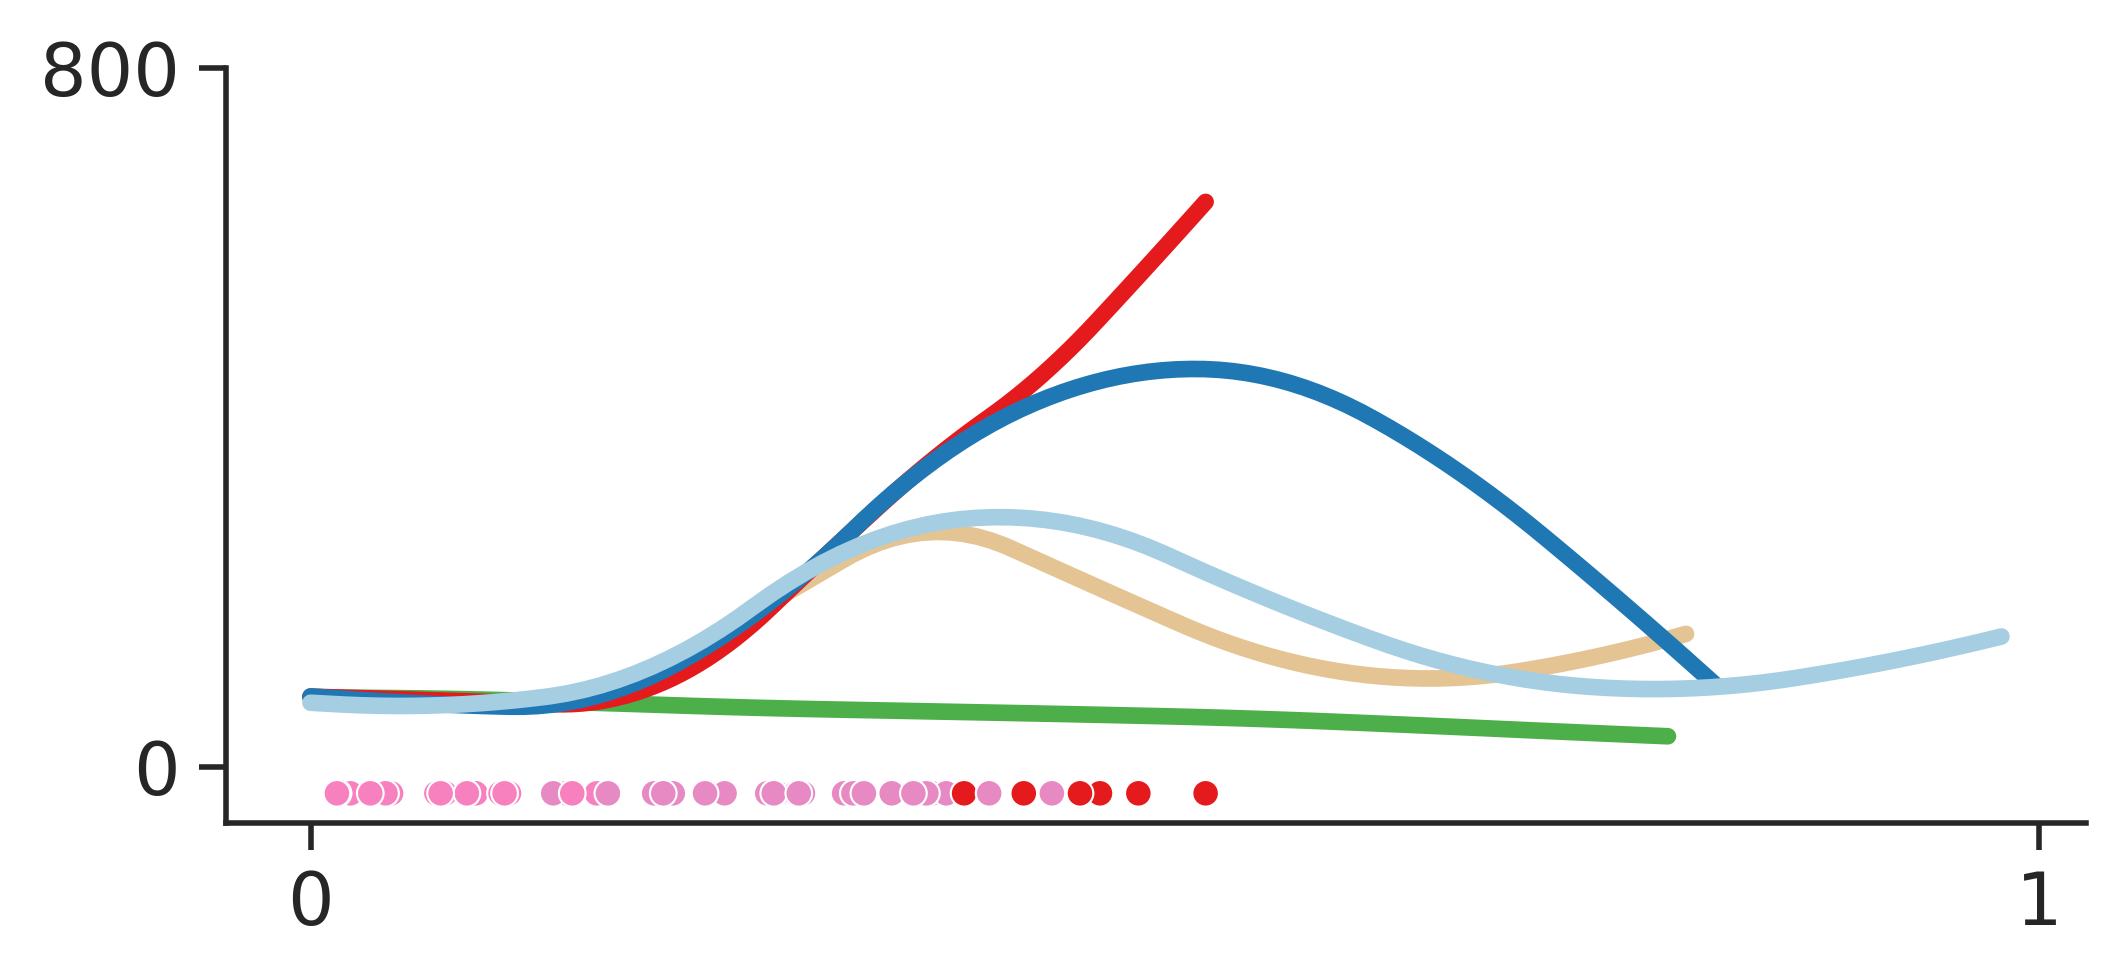

In [438]:
genes = pd.Series(['All','Ery', 'Mono'],index =[
    "CD34",
    "GATA1",  # Erythroid lineage
    "MPO", # Monocyte lineage
])

figsize=[6, 2.5]
for gene in genes.index:
    plt.figure(figsize=figsize)
    for lineage in meta_lineage_cells.index:
        #x = meta_pr_res.pseudotime[meta_lineage_cells[lineage]]
        x = rna_meta_ad.obs.loc[meta_lineage_cells[lineage],'palantir_pseudotime']

        y = meta_imp_df.loc[x.index, gene]
        
        pred_x = np.linspace(0, np.max(x), 100)

        pred_y, std = gam_fit_predict(x.values, y.values,pred_x=pred_x, n_splines=10, spline_order=2)
        plt.plot(pred_x, pred_y, color=ct_colors[lineage], linewidth=3, zorder=1)
    
        # Add cells to bottom
        if genes.loc[gene] == 'All':
            sns.scatterplot(data=rna_meta_ad.obs, x='palantir_pseudotime' ,
                            y=-30, hue='celltype', palette=list(rna_meta_ad.uns['celltype_colors'])
                            , legend=None)
        else:
            sns.scatterplot(data=rna_meta_ad.obs.loc[meta_lineage_cells[genes.loc[gene]]], x='palantir_pseudotime' ,
                            y=-30, hue='celltype', palette=list(rna_meta_ad.uns['celltype_colors'])
                            , legend=None)

    #plt.title(gene)
    plt.xlabel('')
    plt.xticks([0, 1])
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    sns.despine() 
    plt.savefig(plot_prefix + f'{gene}_rna_trend.png', dpi=200, bbox_inches='tight')
 

## cluster level -- not run

In [66]:
cluster_df = sc_imp_df.groupby(rna_ad.obs['leiden']).mean()
cluster_colors = pd.Series(rna_ad.uns['leiden_colors'], 
                          index=rna_ad.obs['leiden'].values.categories)
cluster_pt = sc_pr_res.pseudotime[rna_ad.obs_names].groupby(rna_ad.obs['leiden']).mean()

In [67]:
cluster_colors = sns.color_palette('Set3', len(cluster_colors)).as_hex()
cluster_colors = pd.Series(cluster_colors)
cluster_colors.index = cluster_colors.index.astype(str)

In [68]:
lineage_clusters = pd.Series(dtype=object, index=meta_lineage_cells.index)
lineage_clusters['CLP'] = ['0', '1', '8', '9']
lineage_clusters['Ery'] = ['0', '4', '2']
lineage_clusters['Mono'] = ['0', '1', '8', '3', '5']
lineage_clusters['cDC'] = ['0', '1', '8', '7', '6']
lineage_clusters['pDC'] = ['0', '1', '8', '7', '10']

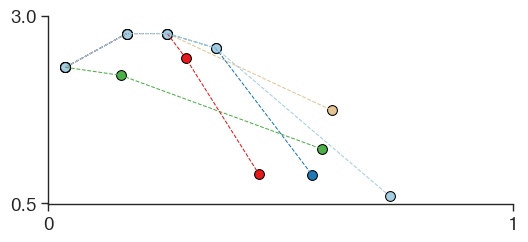

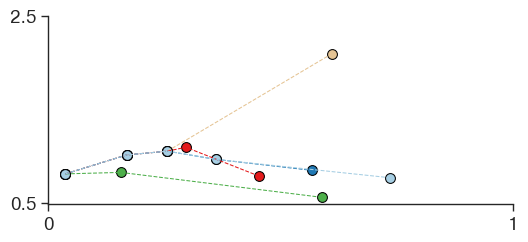

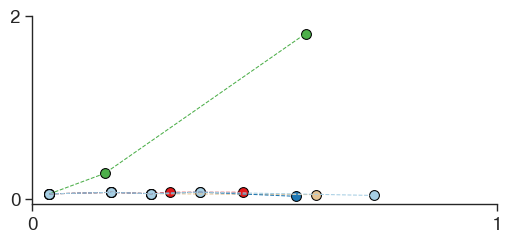

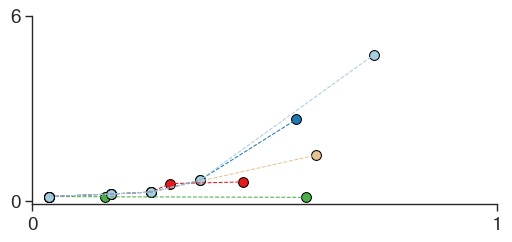

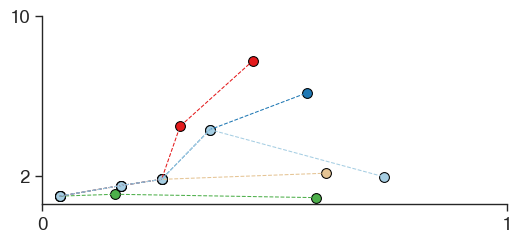

In [69]:
genes = pd.Series([
    "CD34",
    "CD79B", # CLP / B cell lineage 
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
])

figsize=[6, 2.5]
for gene in genes:
    plt.figure(figsize=figsize)
    for lineage in meta_lineage_cells.index:
        clus = lineage_clusters[lineage]
                
        x = cluster_pt[clus]
        y = cluster_df.loc[clus, gene]
        plt.scatter(x, y, color=ct_colors[lineage], s=50, linewidth=0.75, edgecolor='black')
        plt.plot(x, y, color=ct_colors[lineage], linewidth=0.75, zorder=1, linestyle='--')
    plt.xticks([0, 1])
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    sns.despine() 
    plt.savefig(plot_prefix + f'{gene}_cluster.png', dpi=150, bbox_inches='tight')
 



## ATAC accessibility trends

In [441]:
def impute_data2(dm_res, gene_exprs, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    imputed_data = _dot_func(T_steps, gene_exprs)
#     imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

In [442]:
genes = pd.Series([
    "CD34",
    "CD79B", # CLP / B cell lineage 
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
])


In [443]:
# August 2022
# Imputed gene scores - SEACells

df = pd.DataFrame(rna_meta_ad.obsm['X_pca'], index=rna_meta_ad.obs_names)
dm_res = palantir.utils.run_diffusion_maps(df, knn=15)
meta_df = pd.DataFrame(atac_meta_ad.obsm['GeneScores'], 
                          index=atac_meta_ad.obs_names, columns=atac_meta_ad.uns['GeneScoresColumns'])
atac_meta_imp_df = pd.DataFrame(impute_data2(dm_res, meta_df.loc[:, genes]), 
                          index=atac_meta_ad.obs_names, columns=genes)


Determing nearest neighbor graph...


In [444]:
# cluster_df = sc_imp_df.groupby(rna_ad.obs['leiden']).mean()
# cluster_colors = pd.Series(rna_ad.uns['leiden_colors'], 
#                           index=rna_ad.obs['leiden'].values.categories)
# cluster_pt = sc_pr_res.pseudotime[rna_ad.obs_names].groupby(rna_ad.obs['leiden']).mean()

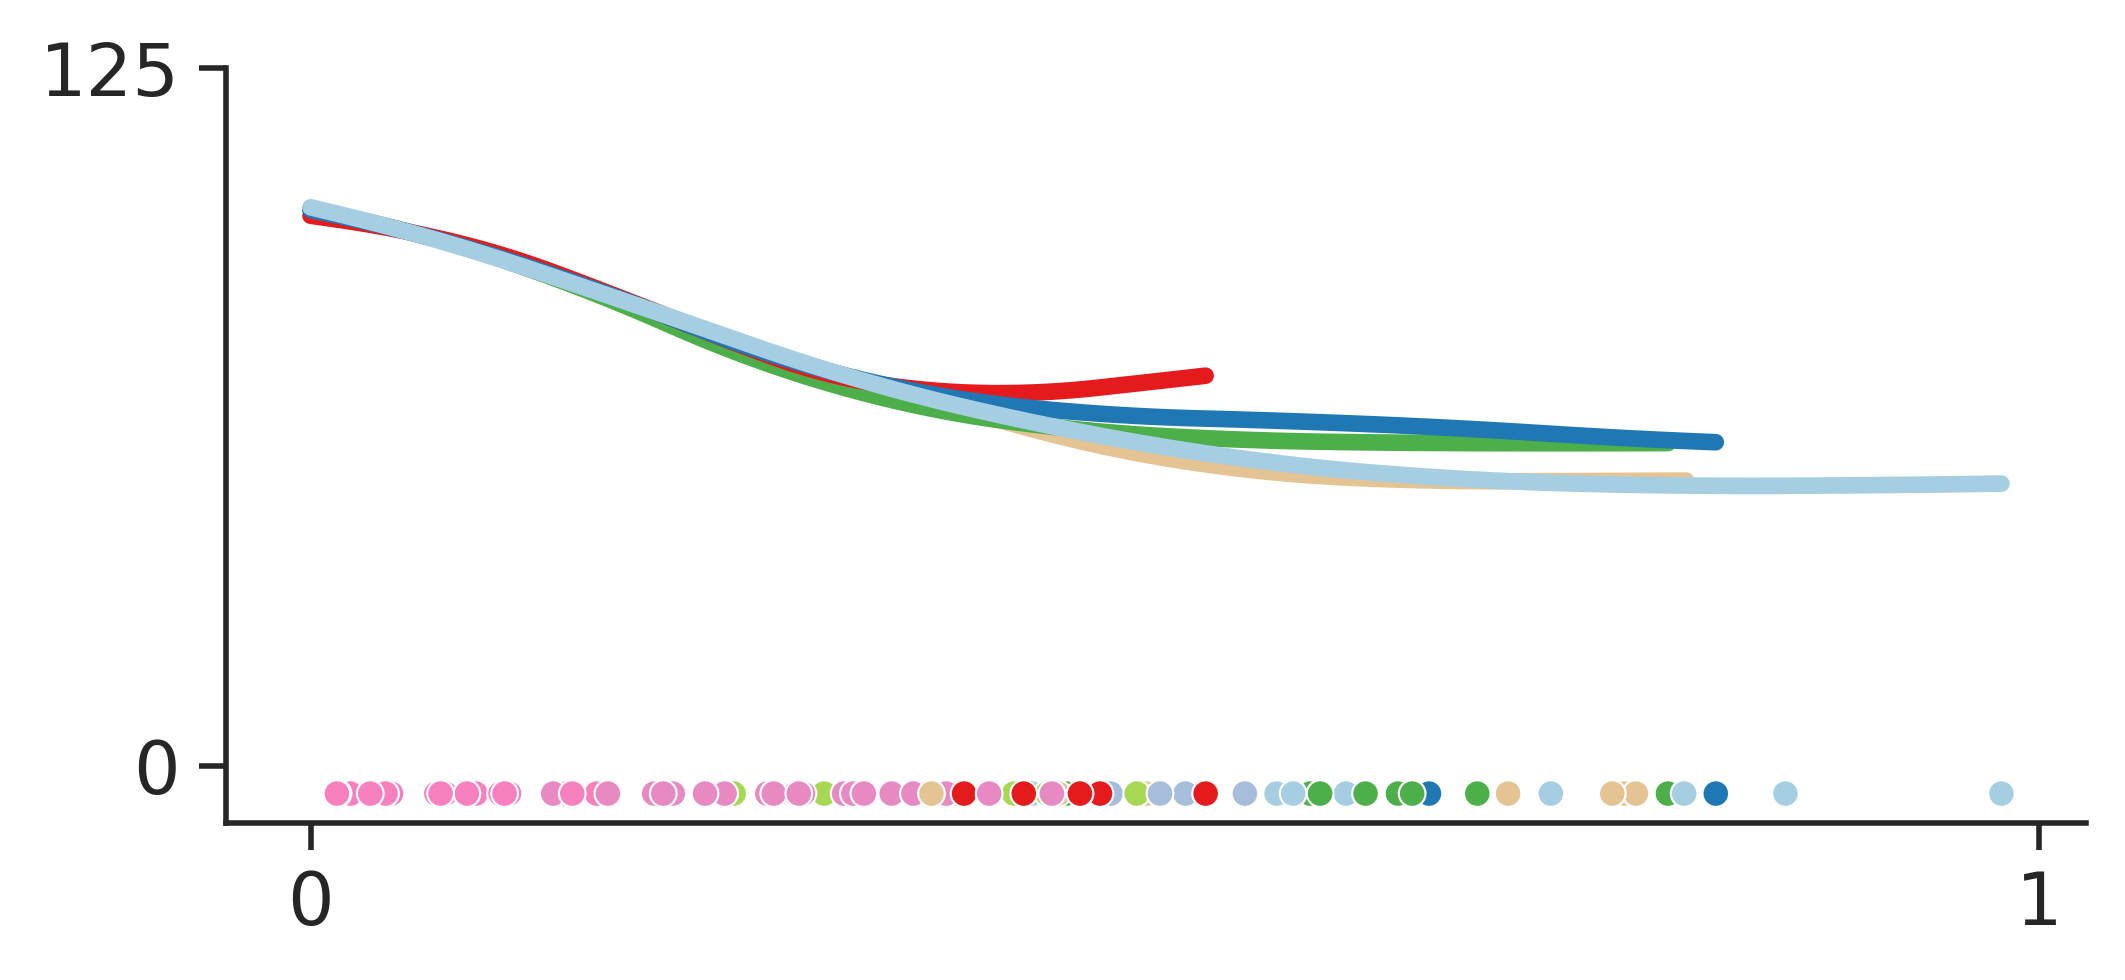

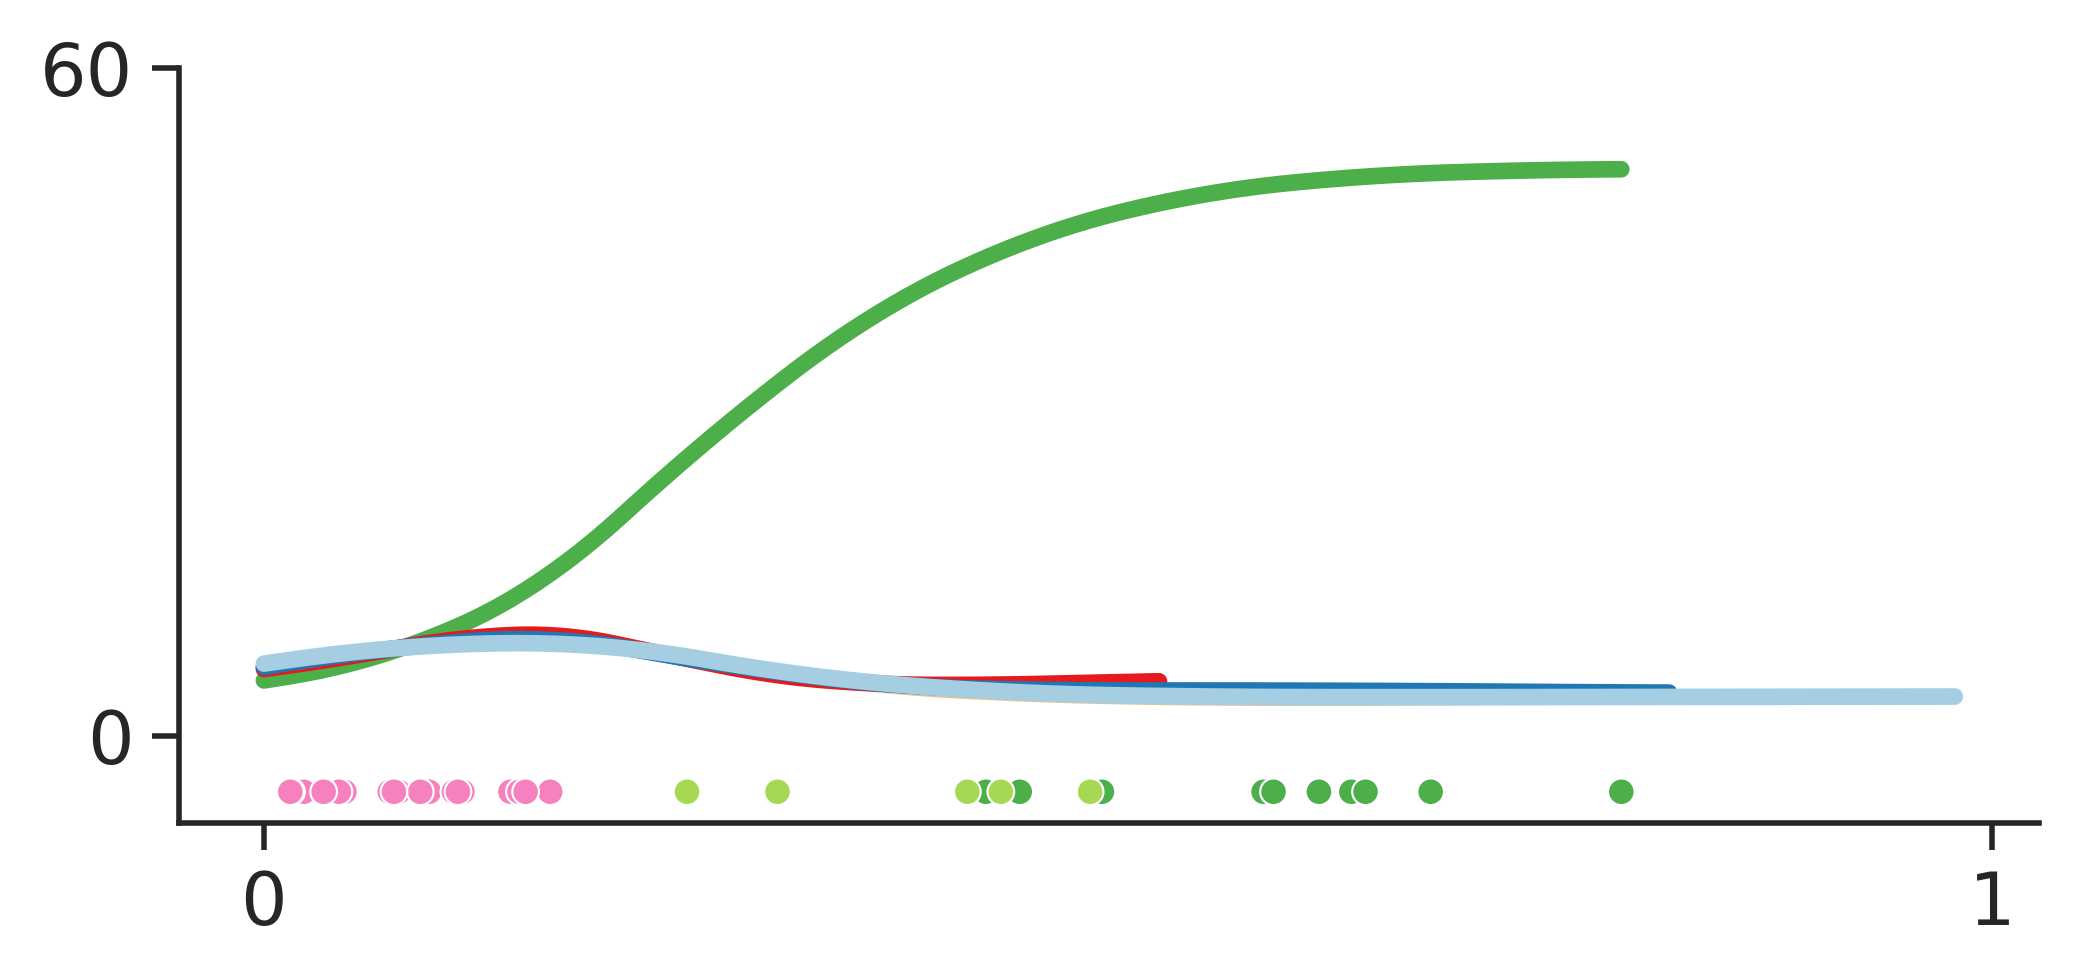

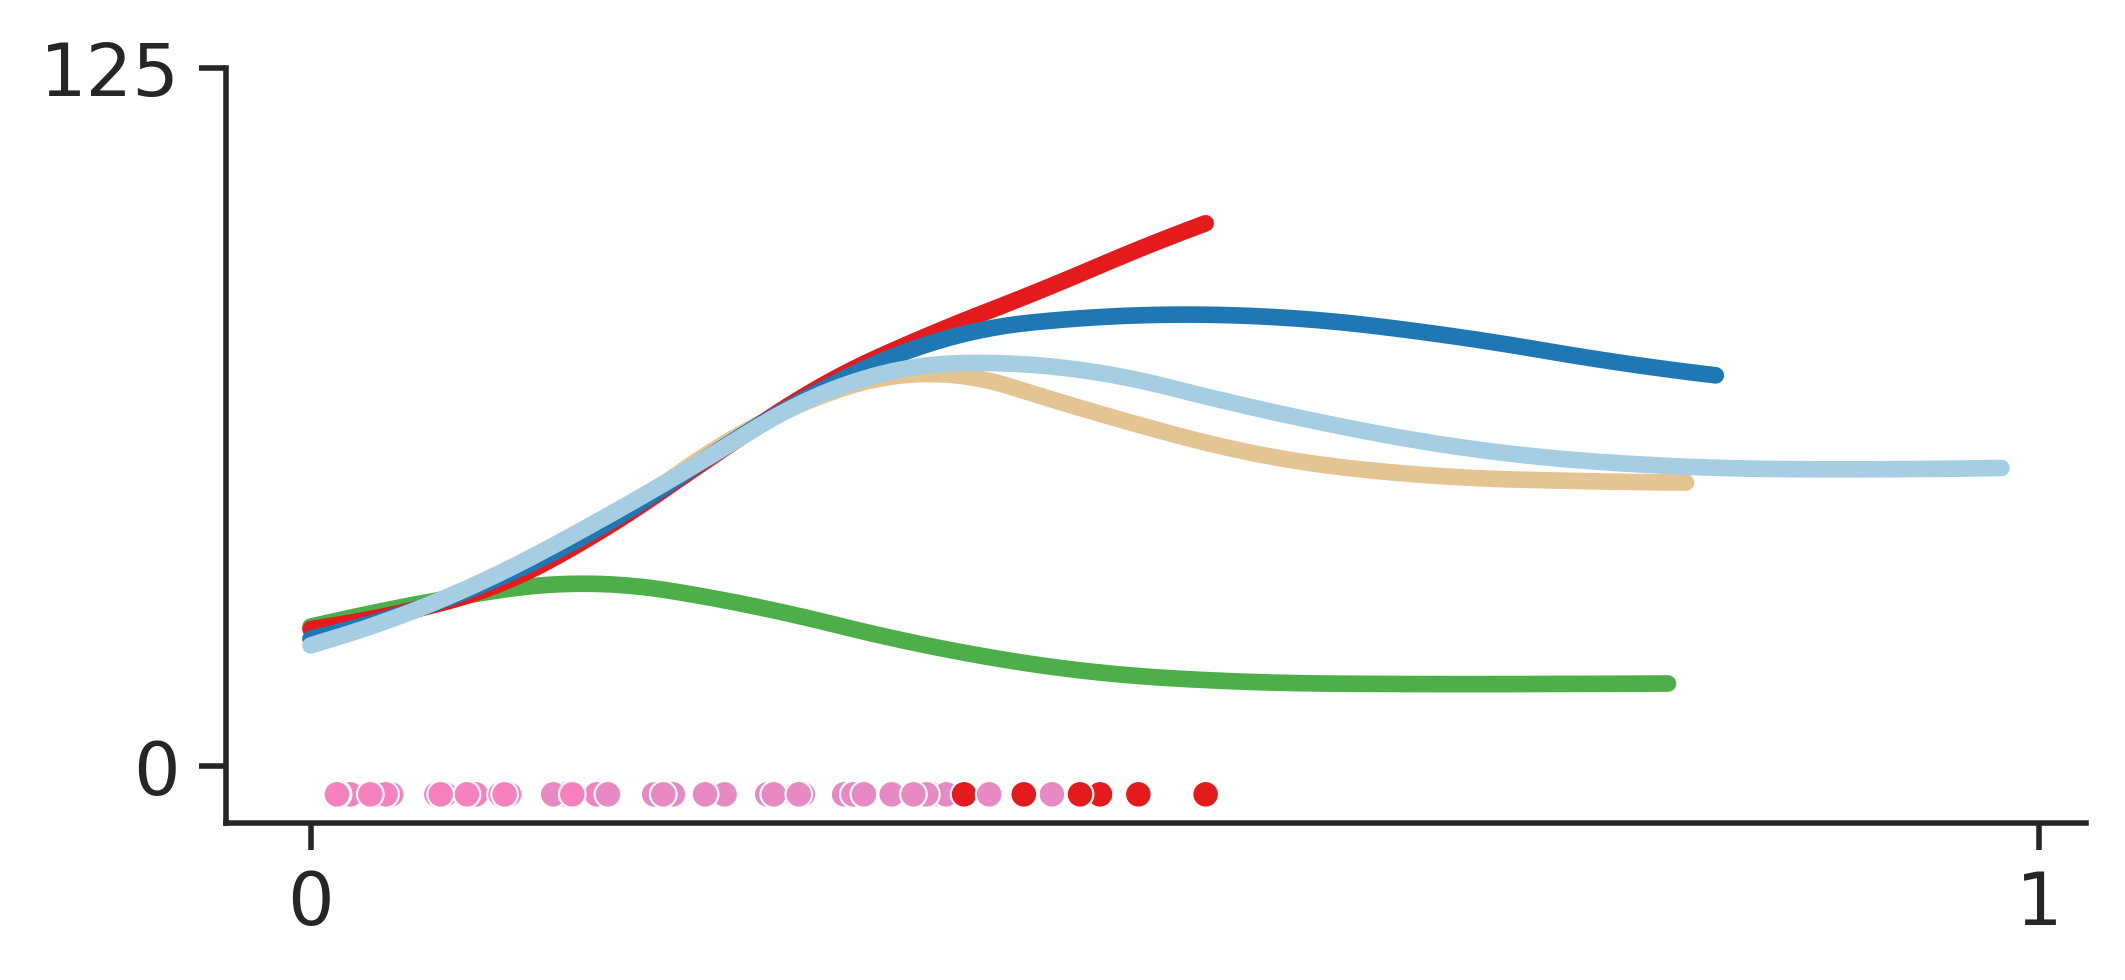

In [445]:
genes = pd.Series(['All','Ery', 'Mono'],index =[
    "CD34",
    "GATA1",  # Erythroid lineage
    "MPO", # Monocyte lineage
])

figsize=[6, 2.5]
for gene in genes.index:
    plt.figure(figsize=figsize)
    for lineage in meta_lineage_cells.index:
        #x = meta_pr_res.pseudotime[meta_lineage_cells[lineage]]
        x = rna_meta_ad.obs.loc[meta_lineage_cells[lineage],'palantir_pseudotime']

        y = atac_meta_imp_df.loc[x.index, gene]
        
        pred_x = np.linspace(0, np.max(x), 100)

        pred_y, std = gam_fit_predict(x.values, y.values,pred_x=pred_x, n_splines=10, spline_order=2)
        plt.plot(pred_x, pred_y, color=ct_colors[lineage], linewidth=3, zorder=1)
    
        # Add cells to bottom
        if genes.loc[gene] == 'All':
            sns.scatterplot(data=rna_meta_ad.obs, x='palantir_pseudotime' ,
                            y=-5, hue='celltype', palette=list(rna_meta_ad.uns['celltype_colors'])
                            , legend=None)
        else:
            sns.scatterplot(data=rna_meta_ad.obs.loc[meta_lineage_cells[genes.loc[gene]]], x='palantir_pseudotime' ,
                            y=-5, hue='celltype', palette=list(rna_meta_ad.uns['celltype_colors'])
                            , legend=None)

    #plt.title(gene)
    plt.xlabel('')
    plt.xticks([0, 1])
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    sns.despine() 
    plt.savefig(plot_prefix + f'{gene}_atac_trend.png', dpi=200, bbox_inches='tight')
 

# PBMC gene expression comparisons

In [18]:
data_dir = os.path.expanduser('/home/ec2-user/projects/metacells/data/PBMCs/10X_Multiome_nogran_10k/')

In [19]:
rna_ad = sc.read(data_dir + 'pbmc_multiome_rna_processed.h5ad')
rna_ad.obs_names= 'pbmc_10x_multiome_atac#' + rna_ad.obs_names

atac_ad = sc.read(data_dir + 'pbmc_multiome_atac.h5ad')
# atac_ad.obs_names = atac_ad.obs_names.str.split('#').str.get(1)

In [20]:
rna_ad

AnnData object with n_obs × n_vars = 11543 × 22020
    obs: 'n_counts', 'log_n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'phenograph', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [21]:
# common = atac_ad.obs_names.intersection(rna_ad.obs_names)
# atac_ad = atac_ad[common, :]
# rna_ad = rna_ad[common, :]

In [30]:
seacells = pd.read_csv(data_dir + 'pbmc_atac_labels.csv', index_col=0)
seacells = seacells.loc[~seacells['Aerocell'].isna(), :]
atac_seacells = seacells
cells = atac_seacells.index.intersection(atac_ad.obs_names)
atac_ad = atac_ad[cells,:]
atac_ad.obs['SEACell'] = atac_seacells['Aerocell'][cells].values


seacells = pd.read_csv(data_dir + 'pbmc_rna_labels.csv', index_col=0)
seacells.index = 'pbmc_10x_multiome_atac#' + seacells.index
rna_seacells = seacells
cells = rna_seacells.index.intersection(rna_ad.obs_names)
rna_ad = rna_ad[cells, :]
rna_ad.obs['SEACell'] = 'pbmc_10x_multiome_atac#' + rna_seacells['Aerocell'][cells].values

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [31]:
rna_ad

AnnData object with n_obs × n_vars = 11079 × 22020
    obs: 'n_counts', 'log_n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [26]:
len(rna_seacells['Aerocell'].unique())

99

In [28]:
11079 / 75

147.72

In [19]:
rna_meta = rna_ad.obs['SEACell'].astype(str).unique()
remmeta = rna_meta[rna_ad[rna_meta].obs['celltype'].isin(['MT high', 'TBD'])]

rna_ad = rna_ad[~rna_ad.obs['celltype'].isin(['MT high', 'TBD']), :]
rna_ad = rna_ad[~rna_ad.obs['SEACell'].isin(remmeta), :]

## RNA SEACells

In [20]:
metacells = rna_ad.obs['SEACell'].astype(str).unique()
metacells = metacells[rna_ad.obs['SEACell'].value_counts()[metacells] > 1]

In [21]:
len(metacells)

96

In [22]:
from tqdm.notebook import tqdm

In [23]:
# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=rna_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = rna_ad.obs_names[rna_ad.obs['SEACell'] == m]
    summ_matrix.loc[m, :] = np.ravel(rna_ad[cells, :].X.sum(axis=0))

In [24]:
# Ann data
# Counts
rna_meta_ad = sc.AnnData(summ_matrix)
rna_meta_ad.X = csr_matrix(rna_meta_ad.X)
rna_meta_ad.obs_names, rna_meta_ad.var_names = summ_matrix.index.astype(str), rna_meta_ad.var_names

In [25]:
rna_meta_ad.raw = sc.AnnData(rna_meta_ad.X)

In [26]:
sc.pp.normalize_per_cell(rna_meta_ad)

In [27]:
rna_meta_ad.obs['celltype'] = rna_ad.obs['celltype'][rna_meta_ad.obs_names]

## ATAC Meta cell 

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
tfidf = TfidfTransformer()
tfidf.fit(atac_ad.X)
atac_ad.layers['TFIDF'] = tfidf.transform(atac_ad.X)

In [30]:
metacells = atac_ad.obs['SEACell'].astype(str).unique()
metacells = metacells[atac_ad.obs['SEACell'].value_counts()[metacells] > 1]

In [31]:
# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=atac_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = atac_ad.obs_names[atac_ad.obs['SEACell'] == m]
    summ_matrix.loc[m, :] = np.ravel(atac_ad[cells, :].layers['TFIDF'].sum(axis=0))

In [32]:
# Ann data
# Counts
atac_meta_ad = sc.AnnData(summ_matrix)
atac_meta_ad.X = csr_matrix(atac_meta_ad.X)
atac_meta_ad.obs_names, atac_meta_ad.var_names = summ_matrix.index.astype(str), summ_matrix.columns

In [33]:
sc.pp.normalize_per_cell(atac_meta_ad)
# log_transform(atac_meta_ad)

In [34]:
## Gene scores
gs = pd.DataFrame(atac_ad.obsm['GeneScores'], 
            index=atac_ad.obs_names, columns=atac_ad.uns['GeneScoresColums'])

# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=gs.columns)

for m in tqdm(summ_matrix.index):
    cells = atac_ad.obs_names[atac_ad.obs['SEACell'] == m]
    summ_matrix.loc[m, :] = np.ravel(gs.loc[cells, :].sum(axis=0))

In [35]:
atac_meta_ad.obsm['GeneScores'] = summ_matrix.loc[atac_meta_ad.obs_names, :]
atac_meta_ad.uns['GeneScoresColumns'] = atac_ad.uns['GeneScoresColums']

## Plots

In [36]:
atac_ad.obs['celltype2'] = atac_ad.obs['celltype'].astype(str).str.replace(' [1-9]', '')
rna_ad.obs['celltype2'] = rna_ad.obs['celltype'].astype(str).str.replace(' [1-9]', '')
# atac_meta_ad.obs['celltype2'] = rna_meta_ad.obs['celltype2'] = rna_ad.obs['celltype2'][rna_meta_ad.obs_names]


Trying to set attribute `.obs` of view, copying.


In [37]:
cell_types = rna_ad.obs['celltype2'].astype(str)
cell_types[cell_types == 'Bcells'] = 'B cells'
rna_ad.obs['celltype2'] = cell_types

cell_types = atac_ad.obs['celltype2'].astype(str)
cell_types[cell_types == 'Bcells'] = 'B cells'
atac_ad.obs['celltype2'] = cell_types

... storing 'SEACell' as categorical
... storing 'celltype2' as categorical


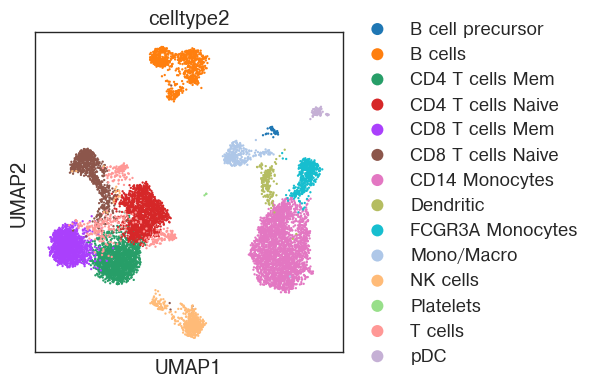

... storing 'SEACell' as categorical
... storing 'celltype2' as categorical


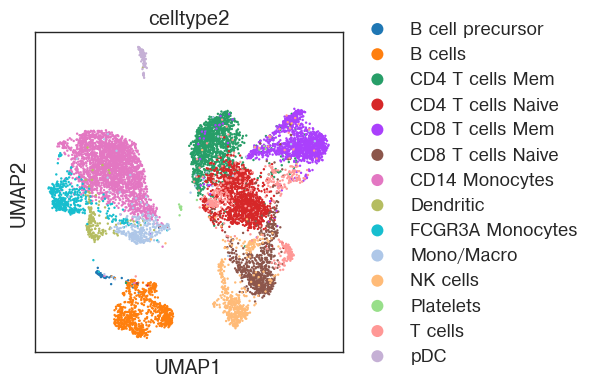

In [265]:
sc.pl.scatter(rna_ad, basis='umap', color='celltype2')
sc.pl.scatter(atac_ad, basis='umap', color='celltype2')

In [266]:
ct_colors = pd.Series(rna_ad.uns['celltype2_colors'], index=rna_ad.obs['celltype2'].values.categories)
ct_colors['CD4 T cells Mem'] = '#f57e20'
ct_colors['CD8 T cells Mem'] = '#2ea048'
ct_colors['CD4 T cells Naive'] = '#fcba78'
ct_colors['CD8 T cells Naive'] = '#9dd089'
ct_colors['CD14 Monocytes'] = '#d52928'
ct_colors['Dendritic'] = '#f69696'
ct_colors['pDC'] = '#c7c7c6'
ct_colors['NK cells'] = '#c49c94'
ct_colors['B cell precursor'] = '#2077b5'
ct_colors['B cells'] = '#aec7e8'
ct_colors['Bcells'] = '#aec7e8'
ct_colors['T cells'] = '#f7b6d1'
ct_colors['FCGR3A Monocytes'] = '#9268ac'
ct_colors['Dendritic'] = '#f69696'
ct_colors['Platelets'] = '#d87ab1'
ct_colors['Mono/Macro'] = '#8c574c'

rna_ad.uns['celltype2_colors'] = ct_colors[rna_ad.obs['celltype2'].values.categories].values
atac_ad.uns['celltype2_colors'] = ct_colors[atac_ad.obs['celltype2'].values.categories].values

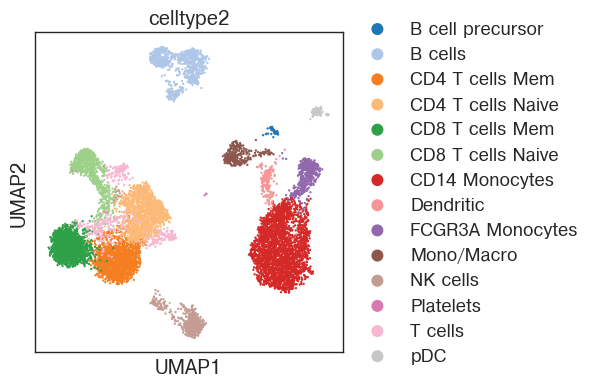

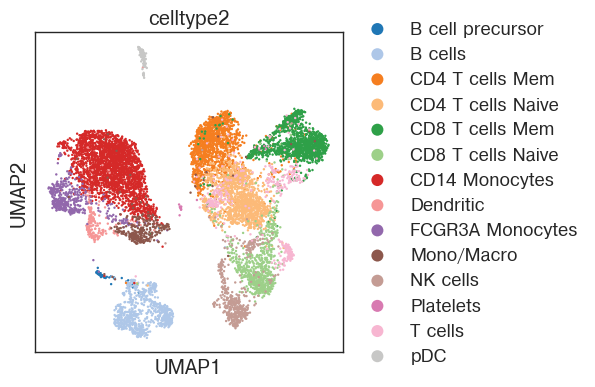

In [267]:
sc.pl.scatter(rna_ad, basis='umap', color='celltype2')
sc.pl.scatter(atac_ad, basis='umap', color='celltype2')

### Result plots

In [268]:
atac_meta_celltypes = atac_ad.obs['celltype2'].groupby(atac_ad.obs['SEACell']).apply(lambda x: x.value_counts().idxmax())

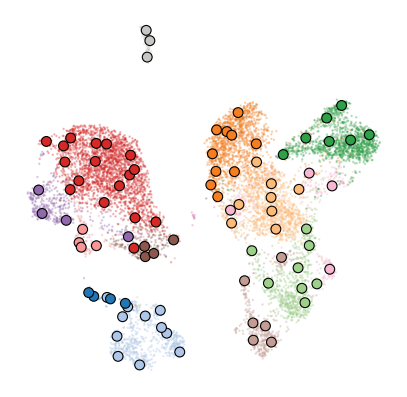

In [209]:
plt.figure(figsize=[5, 5])
ax = plt.gca()
ax.scatter(atac_ad.obsm['X_umap'][:, 0], 
          atac_ad.obsm['X_umap'][:, 1], alpha=0.25,
          s=1, color=ct_colors[atac_ad.obs['celltype2']])

atac_meta = atac_ad.obs['SEACell'].astype(str).unique()
ax.scatter(atac_ad[atac_meta].obsm['X_umap'][:, 0], 
          atac_ad[atac_meta].obsm['X_umap'][:, 1], alpha=1,
          s=50, color=ct_colors[atac_ad[atac_meta].obs['celltype2']], 
          edgecolors='black')


ax.set_axis_off()
plt.savefig(plot_prefix + f'atac_seacell_results.png', dpi=150, bbox_inches='tight')

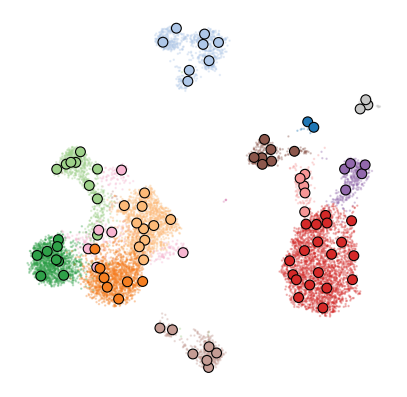

In [210]:
plt.figure(figsize=[5, 5])
ax = plt.gca()
ax.scatter(rna_ad.obsm['X_umap'][:, 0], 
          rna_ad.obsm['X_umap'][:, 1], alpha=0.25,
          s=1, color=ct_colors[rna_ad.obs['celltype2']])

rna_meta = rna_ad.obs['SEACell'].astype(str).unique()
ax.scatter(rna_ad[rna_meta].obsm['X_umap'][:, 0], 
          rna_ad[rna_meta].obsm['X_umap'][:, 1], alpha=1,
          s=50, color=ct_colors[rna_ad[rna_meta].obs['celltype2']], 
          edgecolors='black')


ax.set_axis_off()
plt.savefig(plot_prefix + f'rna_seacell_results.png', dpi=150, bbox_inches='tight')

### Pie charts

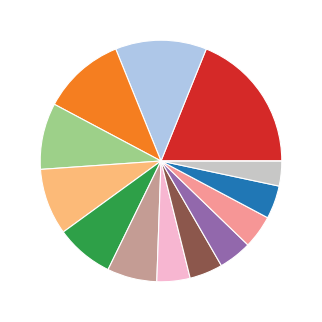

In [211]:
values = atac_ad.obs['celltype2'][atac_meta].value_counts()
plt.pie(values, colors=ct_colors[values.index])
# plt.show() 
plt.savefig(plot_prefix + f'atac_seacell_pie.png', dpi=150, bbox_inches='tight')

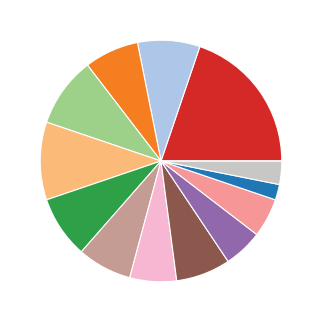

In [212]:
rna_values = rna_ad.obs['celltype2'][rna_meta].value_counts()
plt.pie(rna_values[values.index], colors=ct_colors[values.index])
# plt.show() 
plt.savefig(plot_prefix + f'rna_seacell_pie.png', dpi=150, bbox_inches='tight')

### Purity

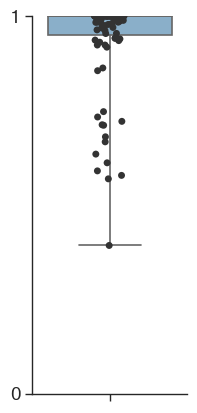

In [213]:
rna_purity = rna_ad.obs['celltype2'].groupby(rna_ad.obs['SEACell']).apply(lambda x: (x.value_counts() / len(x)).max())

plt.figure(figsize=[2, 5])
ax = sns.boxplot(y=rna_purity, whis=np.inf, color='#80b1d3')
ax = sns.stripplot(y=rna_purity, color=".2")
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
sns.despine()
plt.ylabel("")
plt.savefig(plot_prefix + f'rna_seacell_purity.png', dpi=150, bbox_inches='tight')

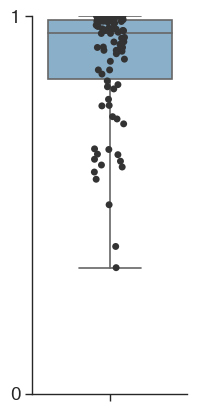

In [214]:
atac_purity = atac_ad.obs['celltype2'].groupby(atac_ad.obs['SEACell']).apply(lambda x: (x.value_counts() / len(x)).max())

plt.figure(figsize=[2, 5])
ax = sns.boxplot(y=atac_purity, whis=np.inf, color='#80b1d3')
ax = sns.stripplot(y=atac_purity, color=".2")
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
sns.despine()
plt.ylabel("")
plt.savefig(plot_prefix + f'atac_seacell_purity.png', dpi=150, bbox_inches='tight')

### RNA

In [215]:
figsize= [3.5, 3.5]

In [249]:
# gene_sets = [['CD4', 'CD8A'], 
#              ['CD8A', 'CD14'], 
#              ['NKG7', 'CD8A'], 
#              ['ITGAM', 'CLEC4C']]

gene_sets = [['CD4', 'CD8A'], 
             ['CD8A', 'CD14'], 
             ['TYROBP', 'CD8A'], 
             ['ITGAM', 'CLEC4C']]
celltypes_set = [['CD4 T cells Mem', 'CD8 T cells Mem'], 
                ['CD8 T cells Naive', 'CD14 Monocytes'], 
                ['CD8 T cells Mem', 'NK cells'], 
                ['pDC', 'Dendritic']]

In [217]:
rna_meta_ad.obs['celltype2'] = rna_ad.obs['celltype2'][rna_meta_ad.obs_names]

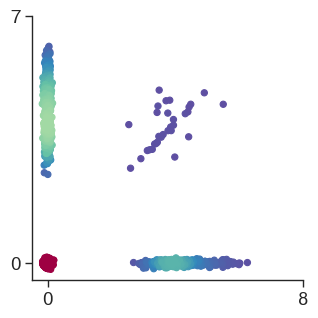

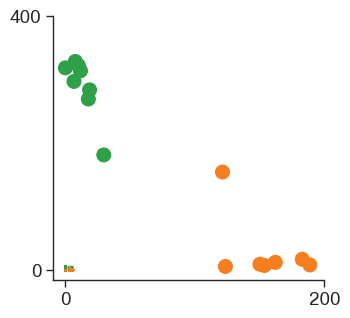

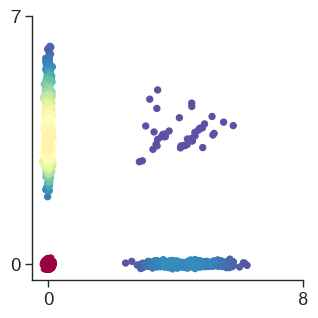

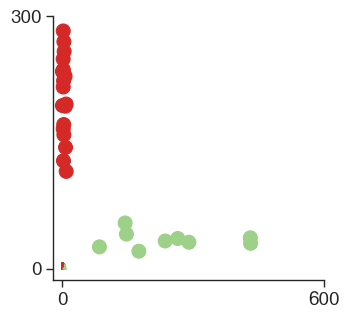

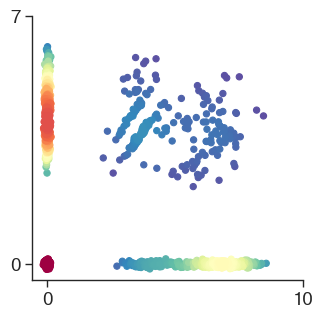

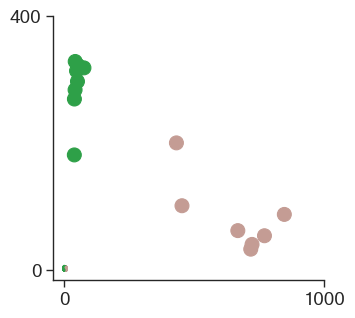

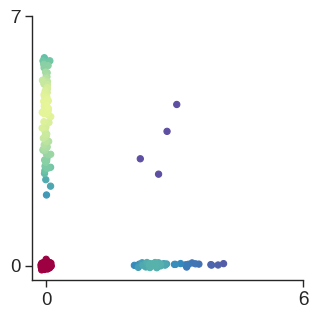

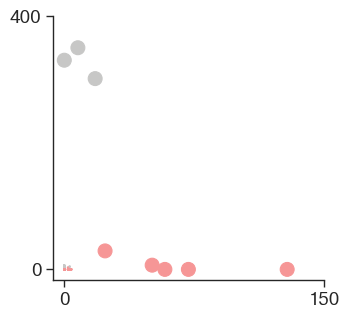

In [218]:
for genes, celltypes in zip(gene_sets, celltypes_set):
    cells = rna_ad.obs_names[rna_ad.obs['celltype2'].isin(celltypes)]
    sc_df = pd.DataFrame(rna_ad[cells][:, genes].X.todense(), 
                index=cells, columns=genes)

    cells = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype2'].isin(celltypes)]
    meta_df = pd.DataFrame(rna_meta_ad[cells][:, genes].X.todense(), 
                index=cells, columns=genes)

    plt.figure(figsize=figsize)
    x, y, z = density_2d(sc_df[genes[0]].values, sc_df[genes[1]].values)
    plt.scatter(x + np.random.normal(0, 0.05, len(x)), 
                y + np.random.normal(0, 0.05, len(y)),
                s=20, c=z)
    sns.despine()
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    l = ax.get_xticks()
    ax.set_xticks([l[1], l[-1]])
    sns.despine()
    plt.savefig(plot_prefix + f'{genes[0]}_singlecell.png', dpi=150, bbox_inches='tight')

    plt.figure(figsize=figsize)
    plt.scatter(sc_df[genes[0]].values, sc_df[genes[1]].values, 
                s=1, color=ct_colors[rna_ad.obs['celltype2'][sc_df.index]])

    plt.scatter(meta_df[genes[0]].values, meta_df[genes[1]].values, 
                s=100, color=ct_colors[rna_ad.obs['celltype2'][meta_df.index]])
    sns.despine()
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    l = ax.get_xticks()
    ax.set_xticks([l[1], l[-1]])
    sns.despine()
    plt.savefig(plot_prefix + f'{genes[0]}_seacell.png', dpi=150, bbox_inches='tight')

#### Cell type markers

In [38]:
rna_meta_ad.obsm['X_umap'] = rna_ad[rna_meta_ad.obs_names].obsm['X_umap']

In [39]:
genes = ['CD3D', 'CD4', 'CD8A', 'NKG7', 'CD14', 'FCGR3A', 'CD79B', 'IRF8']

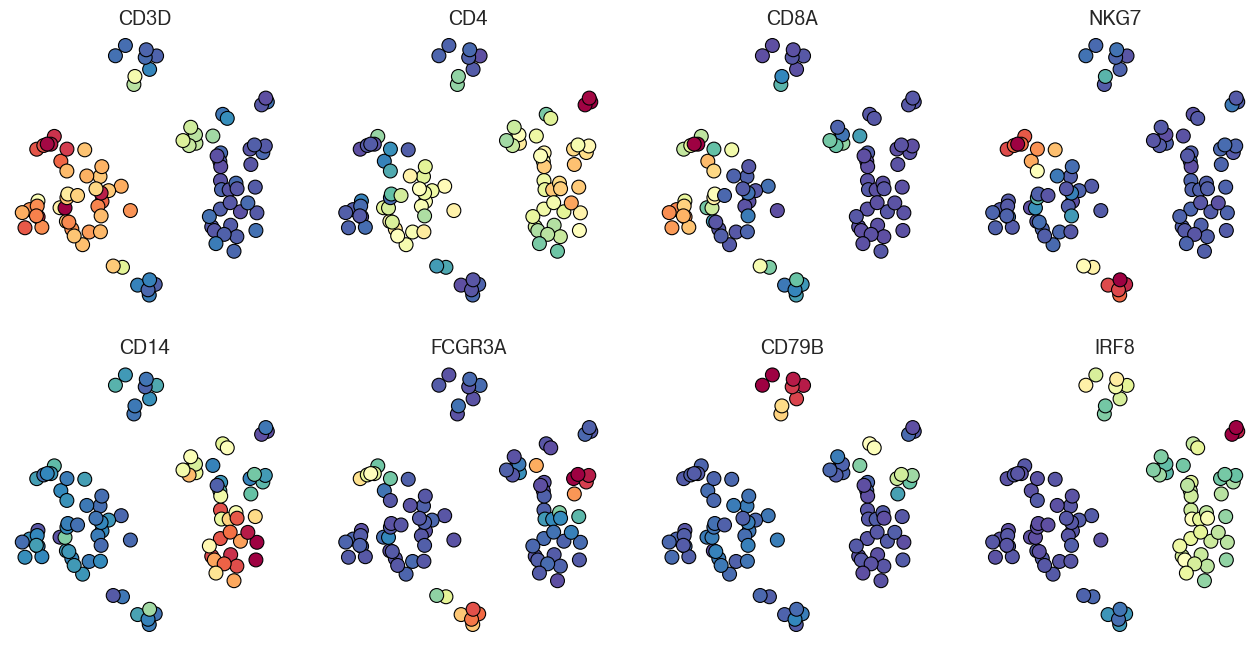

In [40]:
nrows,ncols = 2, 4
fig = plt.figure(figsize=[4 * ncols, 4 * nrows])

for i, gene in enumerate(genes):
    ax = fig.add_subplot(nrows, ncols, i + 1)
    values = np.ravel(rna_meta_ad[:, gene].X.todense())
    ax.scatter(rna_meta_ad.obsm['X_umap'][:, 0], 
               rna_meta_ad.obsm['X_umap'][:, 1], 
               s=100, c=values, edgecolor='black', 
               vmin=np.percentile(values, 1), 
               vmax=np.percentile(values, 99)
              )
    ax.set_title(gene)
    ax.set_axis_off()
plt.savefig(plot_prefix + f'pbmc_rna_markers.png', dpi=150, bbox_inches='tight')

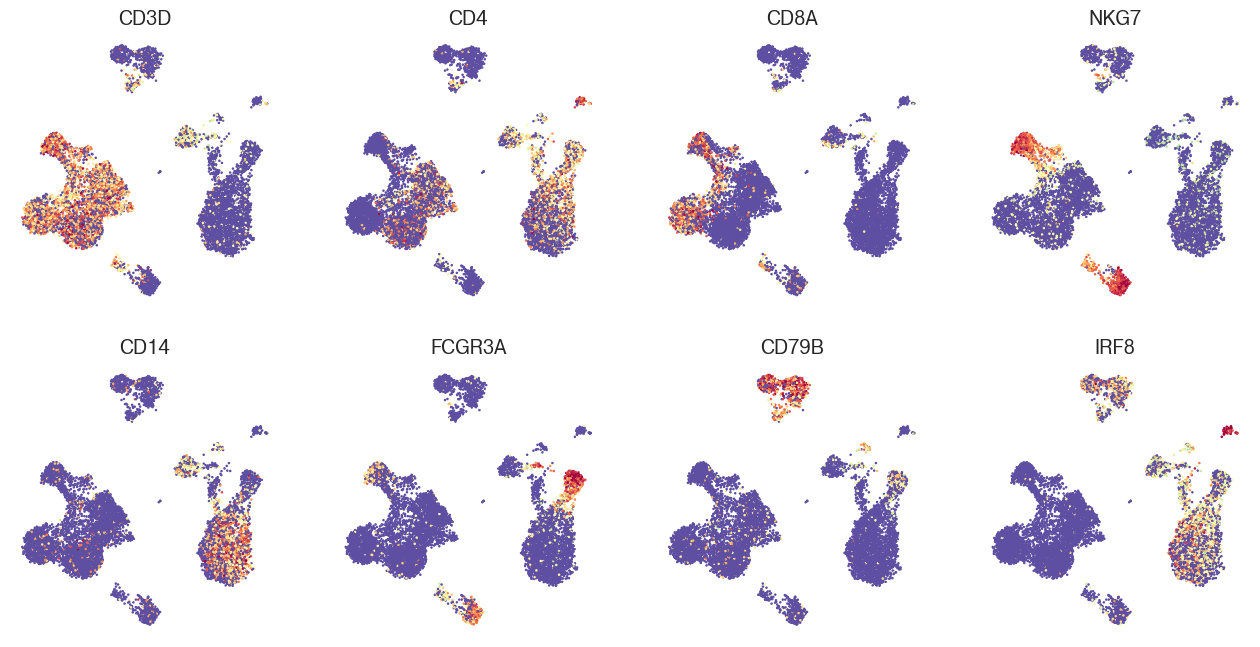

In [43]:
nrows,ncols = 2, 4
fig = plt.figure(figsize=[4 * ncols, 4 * nrows])

for i, gene in enumerate(genes):
    ax = fig.add_subplot(nrows, ncols, i + 1)
    values = np.ravel(rna_ad[:, gene].X.todense())
    ax.scatter(rna_ad.obsm['X_umap'][:, 0], 
               rna_ad.obsm['X_umap'][:, 1], 
               s=1, c=values, #edgecolor='black', 
               vmin=np.percentile(values, 0.5), 
               vmax=np.percentile(values, 99.5)
              )
    ax.set_title(gene)
    ax.set_axis_off()
plt.savefig(plot_prefix + f'pbmc_rna_markers_sc.png', dpi=150, bbox_inches='tight')

### ATAC

In [44]:
from scipy.sparse import csr_matrix

sc_gs_ad = sc.AnnData(csr_matrix(atac_ad.obsm['GeneScores']))
sc_gs_ad.obs_names, sc_gs_ad.var_names = atac_ad.obs_names, atac_ad.uns['GeneScoresColums']

meta_gs_ad = sc.AnnData(csr_matrix(atac_meta_ad.obsm['GeneScores']))
meta_gs_ad.obs_names, meta_gs_ad.var_names = atac_meta_ad.obs_names, atac_meta_ad.uns['GeneScoresColumns']

In [45]:
atac_meta_ad.obs['celltype2'] = atac_ad.obs['celltype2'][atac_meta_ad.obs_names]

In [ ]:
for genes, celltypes in zip(gene_sets, celltypes_set):
    cells = atac_ad.obs_names[atac_ad.obs['celltype2'].isin(celltypes)]
    sc_df = pd.DataFrame(sc_gs_ad[cells][:, genes].X.todense(), 
                index=cells, columns=genes)

    cells = atac_meta_ad.obs_names[atac_meta_ad.obs['celltype2'].isin(celltypes)]
    meta_df = pd.DataFrame(meta_gs_ad[cells][:, genes].X.todense(), 
                index=cells, columns=genes)

    plt.figure(figsize=figsize)
    x, y, z = density_2d(sc_df[genes[0]].values, sc_df[genes[1]].values)
    plt.scatter(x + np.random.normal(0, 0.05, len(x)), 
                y + np.random.normal(0, 0.05, len(y)),
                s=20, c=z)
    sns.despine()
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    l = ax.get_xticks()
    ax.set_xticks([l[1], l[-1]])
    sns.despine()
    #plt.savefig(plot_prefix + f'{genes[0]}_singlecell_atac.png', dpi=150, bbox_inches='tight')

    plt.figure(figsize=figsize)
    plt.scatter(sc_df[genes[0]].values, sc_df[genes[1]].values, 
                s=1, color=ct_colors[atac_ad.obs['celltype2'][sc_df.index]])

    plt.scatter(meta_df[genes[0]].values, meta_df[genes[1]].values, 
                s=100, color=ct_colors[atac_ad.obs['celltype2'][meta_df.index]])
    sns.despine()
    ax = plt.gca()
    l = ax.get_yticks()
    ax.set_yticks([l[1], l[-1]])
    l = ax.get_xticks()
    ax.set_xticks([l[1], l[-1]])
    sns.despine()
    #plt.savefig(plot_prefix + f'{genes[0]}_seacell_atac.png', dpi=150, bbox_inches='tight')

#### Cell type markers

In [46]:
atac_meta_ad

AnnData object with n_obs × n_vars = 90 × 177687
    obs: 'n_counts', 'celltype2'
    uns: 'GeneScoresColumns'
    obsm: 'GeneScores'

In [47]:
atac_gs = sc.AnnData(atac_meta_ad.obsm['GeneScores'])
atac_gs.obs_names = atac_meta_ad.obs_names
atac_gs.var_names = atac_meta_ad.uns['GeneScoresColumns']

In [48]:
atac_gs.obsm['X_umap'] = atac_ad[atac_gs.obs_names].obsm['X_umap']

In [49]:
genes = ['CD3D', 'CD4', 'CD8A', 'NKG7', 'CD14', 'FCGR3A', 'CD79B', 'IRF8']

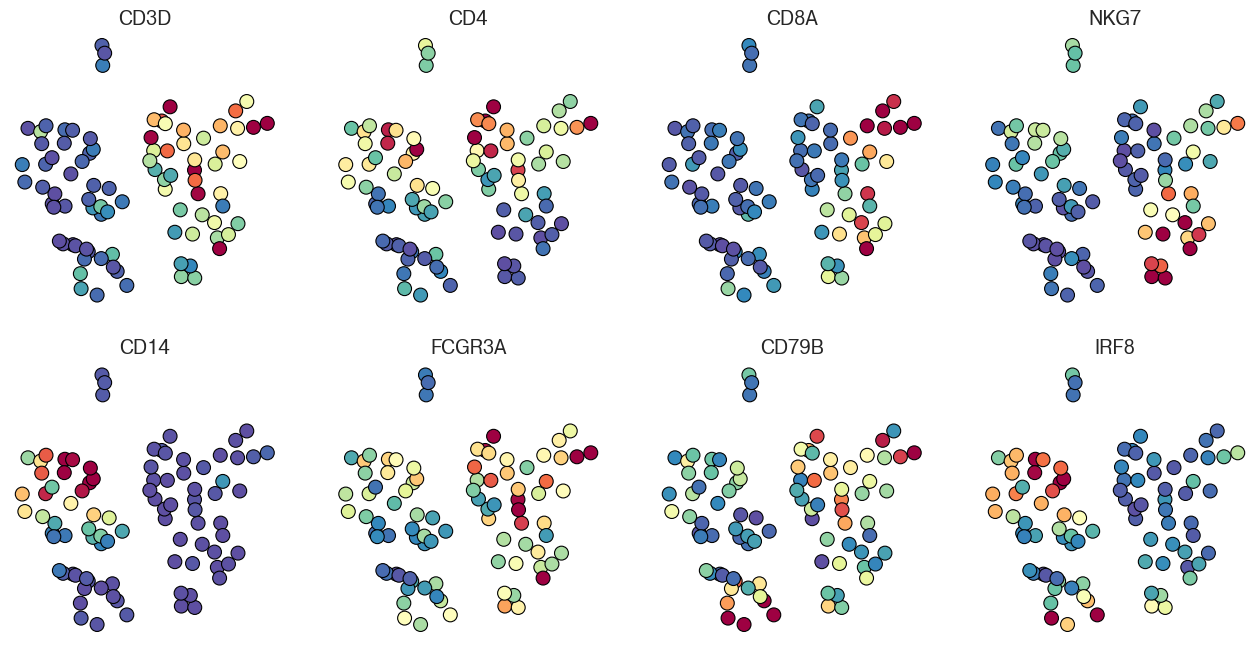

In [50]:
nrows,ncols = 2, 4
fig = plt.figure(figsize=[4 * ncols, 4 * nrows])

for i, gene in enumerate(genes):
    ax = fig.add_subplot(nrows, ncols, i + 1)
    values = np.ravel(atac_gs[:, gene].X)
    ax.scatter(atac_gs.obsm['X_umap'][:, 0], 
               atac_gs.obsm['X_umap'][:, 1], 
               s=100, c=values, edgecolor='black', 
               vmin=np.percentile(values, 0), 
               vmax=np.percentile(values, 95)
              )
    ax.set_title(gene)
    ax.set_axis_off()
plt.savefig(plot_prefix + f'pbmc_atac_markers.png', dpi=150, bbox_inches='tight')

In [ ]:
nrows,ncols = 2, 4
fig = plt.figure(figsize=[4 * ncols, 4 * nrows])

for i, gene in enumerate(genes):
    ax = fig.add_subplot(nrows, ncols, i + 1)
    values = np.ravel(sc_gs_ad[:, gene].X.todense())
    ax.scatter(atac_ad.obsm['X_umap'][:, 0], 
               atac_ad.obsm['X_umap'][:, 1], 
               s=1, c=values, #edgecolor='black', 
               vmin=np.percentile(values, 0.5), 
               vmax=np.percentile(values, 99.5)
              )
    ax.set_title(gene)
    ax.set_axis_off()
plt.savefig(plot_prefix + f'pbmc_atac_markers_sc.png', dpi=150, bbox_inches='tight')

## Mapping

### ATAC projected to RNA

In [251]:
metacells = rna_ad.obs['SEACell'].astype(str).unique()
metacells = metacells[rna_ad.obs['SEACell'].value_counts()[metacells] > 1]

len(metacells)

from tqdm.notebook import tqdm

# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=rna_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = rna_ad.obs_names[rna_ad.obs['SEACell'] == m]
    summ_matrix.loc[m, :] = np.ravel(rna_ad[cells, :].X.sum(axis=0))

# Ann data
# Counts
rna_rnameta_ad = sc.AnnData(summ_matrix)
rna_rnameta_ad.X = csr_matrix(rna_rnameta_ad.X)
rna_rnameta_ad.obs_names, rna_rnameta_ad.var_names = summ_matrix.index.astype(str), rna_rnameta_ad.var_names

rna_rnameta_ad.raw = sc.AnnData(rna_rnameta_ad.X)

# sc.pp.normalize_per_cell(rna_rnameta_ad)

# rna_meta_ad.obs['celltype'] = rna_ad.obs['celltype'][rna_meta_ad.obs_names]

In [252]:
metacells = atac_ad.obs['SEACell'].astype(str).unique()
metacells = metacells[atac_ad.obs['SEACell'].value_counts()[metacells] > 1]

len(metacells)

from tqdm.notebook import tqdm

# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=rna_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = atac_ad.obs_names[atac_ad.obs['SEACell'] == m]
    cells = cells.intersection(rna_ad.obs_names)
    summ_matrix.loc[m, :] = np.ravel(rna_ad[cells, :].X.sum(axis=0))

# Ann data
# Counts
rna_atacmeta_ad = sc.AnnData(summ_matrix)
rna_atacmeta_ad.X = csr_matrix(rna_atacmeta_ad.X)
rna_atacmeta_ad.obs_names, rna_atacmeta_ad.var_names = summ_matrix.index.astype(str), rna_atacmeta_ad.var_names

rna_atacmeta_ad.raw = sc.AnnData(rna_atacmeta_ad.X)

# sc.pp.normalize_per_cell(rna_rnameta_ad)

# rna_meta_ad.obs['celltype'] = rna_ad.obs['celltype'][rna_meta_ad.obs_names]

In [253]:
rna_rnameta_ad.obs['datatype'] = 'RNA'
rna_atacmeta_ad.obs['datatype'] = 'ATAC'

rna_rnameta_ad.obs['celltype'] = rna_ad.obs['celltype2'][rna_rnameta_ad.obs_names].astype(str)
rna_atacmeta_ad.obs['celltype'] = atac_ad.obs['celltype2'][rna_atacmeta_ad.obs_names].astype(str)


rna_meta_celltypes = rna_ad.obs['celltype2'].groupby(rna_ad.obs['SEACell']).apply(lambda x: x.value_counts().idxmax())
rna_rnameta_ad.obs['celltype'] = rna_meta_celltypes[rna_rnameta_ad.obs_names]

atac_meta_celltypes = atac_ad.obs['celltype2'].groupby(atac_ad.obs['SEACell']).apply(lambda x: x.value_counts().idxmax())
rna_atacmeta_ad.obs['celltype'] = atac_meta_celltypes[rna_atacmeta_ad.obs_names]

In [254]:
rna_rnameta_ad.obs_names = 'RNA|' +  rna_rnameta_ad.obs_names
rna_atacmeta_ad.obs_names = 'ATAC|' +  rna_atacmeta_ad.obs_names

In [255]:
comb_ad = rna_atacmeta_ad.concatenate(rna_rnameta_ad, batch_key='batch', index_unique=None)

In [256]:
comb_ad = comb_ad[comb_ad.obs['celltype'] != 'T cells', :]

In [257]:
sc.pp.normalize_per_cell(comb_ad)
comb_ad.var['highly_variable'] = rna_ad.var['highly_variable']

Trying to set attribute `.obs` of view, copying.


In [258]:
sc.pp.pca(comb_ad)

In [259]:
sc.pp.neighbors(comb_ad)
sc.tl.umap(comb_ad)

... storing 'datatype' as categorical
... storing 'celltype' as categorical


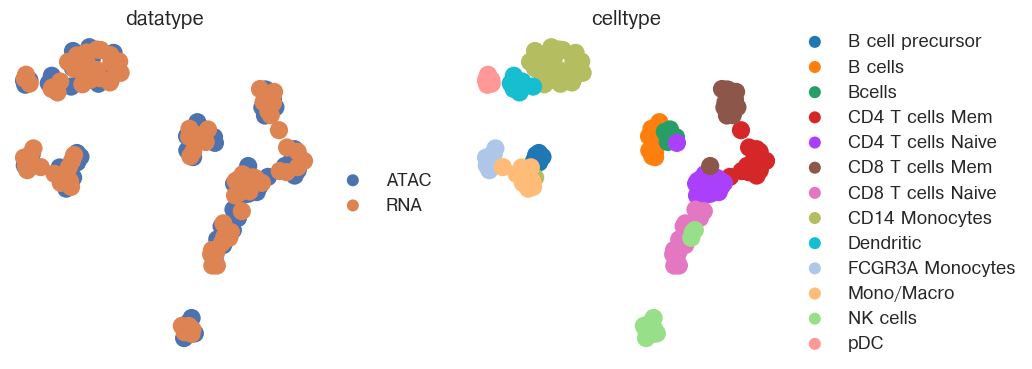

In [260]:
sc.pl.scatter(comb_ad, basis='umap', color=['datatype', 'celltype'], frameon=False)

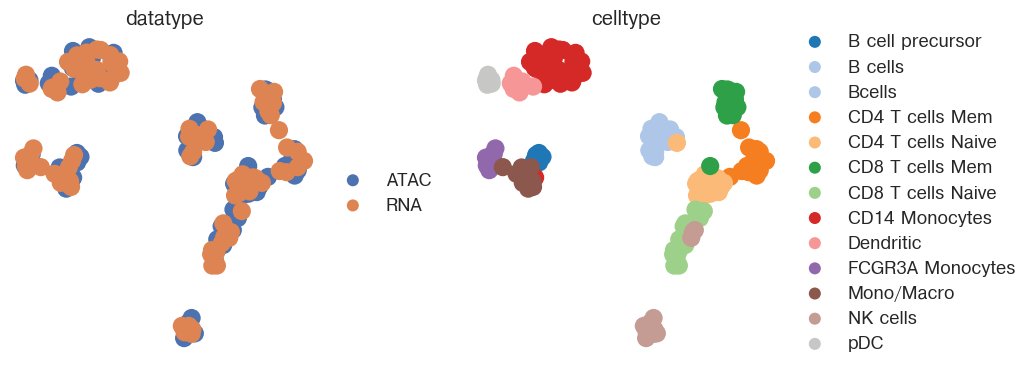

In [269]:
comb_ad.uns['celltype_colors'] = ct_colors[comb_ad.obs['celltype'].values.categories]
sc.pl.scatter(comb_ad, basis='umap', color=['datatype', 'celltype'], frameon=False)

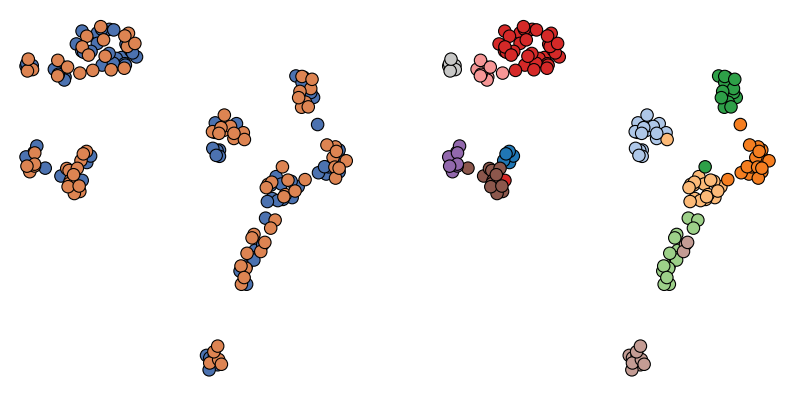

In [282]:
fig = plt.figure(figsize=[10, 5])

order = np.random.choice(comb_ad.obs_names, comb_ad.shape[0], False)

ax = fig.add_subplot(121)
ax.scatter(comb_ad[order].obsm['X_umap'][:, 0], 
            comb_ad[order].obsm['X_umap'][:, 1], 
            edgecolors='black',
            s=80, color=pd.Series(comb_ad.uns['datatype_colors'], index=comb_ad[order].obs['datatype'].values.categories)[comb_ad.obs['datatype']]
           )
ax = plt.gca()
ax.set_axis_off()

ax = fig.add_subplot(122)
ax.scatter(comb_ad[order].obsm['X_umap'][:, 0], 
            comb_ad[order].obsm['X_umap'][:, 1], 
            edgecolors='black',
            s=80, color=ct_colors[comb_ad[order].obs['celltype']]
           )
ax = plt.gca()
ax.set_axis_off()

plt.savefig(plot_prefix + f'pbmc_atac_projected_on_rna.png', dpi=150, bbox_inches='tight')

### RNA projected to ATAC

In [283]:
metacells = atac_ad.obs['SEACell'].astype(str).unique()
metacells = metacells[atac_ad.obs['SEACell'].value_counts()[metacells] > 1]

len(metacells)

from tqdm.notebook import tqdm

# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=atac_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = atac_ad.obs_names[atac_ad.obs['SEACell'] == m]
    summ_matrix.loc[m, :] = np.ravel(atac_ad[cells, :].layers['TFIDF'].sum(axis=0))
    
# Ann data
# Counts
atac_atacmeta_ad = sc.AnnData(summ_matrix)
atac_atacmeta_ad.X = csr_matrix(atac_atacmeta_ad.X)
atac_atacmeta_ad.obs_names, atac_atacmeta_ad.var_names = summ_matrix.index.astype(str), atac_atacmeta_ad.var_names


# sc.pp.normalize_per_cell(rna_rnameta_ad)

# rna_meta_ad.obs['celltype'] = rna_ad.obs['celltype'][rna_meta_ad.obs_names]

In [284]:
metacells = rna_ad.obs['SEACell'].astype(str).unique()
metacells = metacells[rna_ad.obs['SEACell'].value_counts()[metacells] > 1]

len(metacells)

from tqdm.notebook import tqdm

# Summary matrix
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=atac_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = rna_ad.obs_names[rna_ad.obs['SEACell'] == m]
    cells = cells.intersection(atac_ad.obs_names)
    summ_matrix.loc[m, :] = np.ravel(atac_ad[cells, :].layers['TFIDF'].sum(axis=0))

# Ann data
# Counts
atac_rnameta_ad = sc.AnnData(summ_matrix)
atac_rnameta_ad.X = csr_matrix(atac_rnameta_ad.X)
atac_rnameta_ad.obs_names, atac_rnameta_ad.var_names = summ_matrix.index.astype(str), atac_rnameta_ad.var_names

# rna_atacmeta_ad.raw = sc.AnnData(rna_atacmeta_ad.X)

# sc.pp.normalize_per_cell(rna_rnameta_ad)

# rna_meta_ad.obs['celltype'] = rna_ad.obs['celltype'][rna_meta_ad.obs_names]

In [285]:
atac_rnameta_ad.obs['datatype'] = 'RNA'
atac_atacmeta_ad.obs['datatype'] = 'ATAC'

# rna_rnameta_ad.obs['celltype'] = rna_ad.obs['celltype2'][rna_rnameta_ad.obs_names].astype(str)
# rna_atacmeta_ad.obs['celltype'] = atac_ad.obs['celltype2'][rna_atacmeta_ad.obs_names].astype(str)


rna_meta_celltypes = rna_ad.obs['celltype2'].groupby(rna_ad.obs['SEACell']).apply(lambda x: x.value_counts().idxmax())
atac_rnameta_ad.obs['celltype'] = rna_meta_celltypes[atac_rnameta_ad.obs_names]

atac_meta_celltypes = atac_ad.obs['celltype2'].groupby(atac_ad.obs['SEACell']).apply(lambda x: x.value_counts().idxmax())
atac_atacmeta_ad.obs['celltype'] = atac_meta_celltypes[atac_atacmeta_ad.obs_names]

In [286]:
atac_rnameta_ad.obs_names = 'RNA|' +  atac_rnameta_ad.obs_names
atac_atacmeta_ad.obs_names = 'ATAC|' +  atac_atacmeta_ad.obs_names

In [287]:
comb_ad = atac_atacmeta_ad.concatenate(atac_rnameta_ad, batch_key='batch', index_unique=None)

In [288]:
comb_ad = comb_ad[comb_ad.obs['celltype'] != 'T cells', :]

In [289]:
sc.pp.normalize_per_cell(comb_ad)

Trying to set attribute `.obs` of view, copying.


In [290]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=31)
comb_ad.obsm['X_pca'] = svd.fit_transform(comb_ad.X)[:, 1:]

In [291]:
sc.pp.neighbors(comb_ad)
sc.tl.umap(comb_ad)

... storing 'datatype' as categorical
... storing 'celltype' as categorical


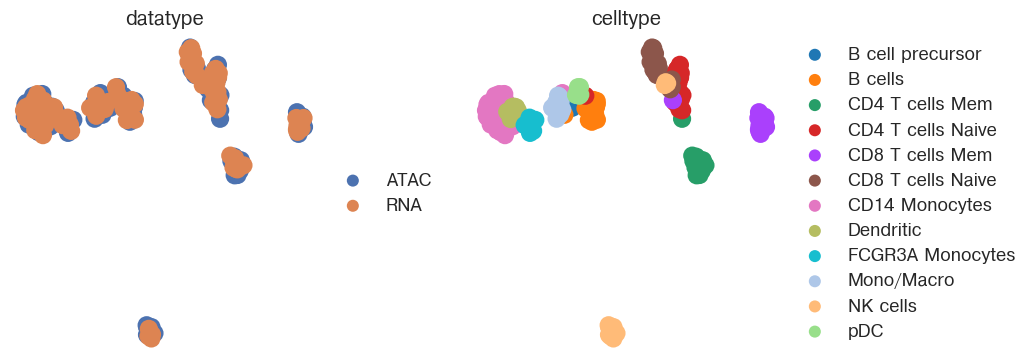

In [292]:
sc.pl.scatter(comb_ad, basis='umap', color=['datatype', 'celltype'], frameon=False)

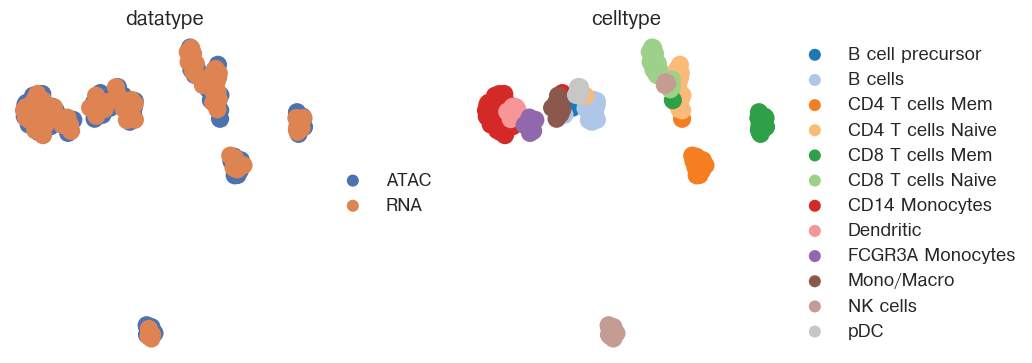

In [293]:
comb_ad.uns['celltype_colors'] = ct_colors[comb_ad.obs['celltype'].values.categories]
sc.pl.scatter(comb_ad, basis='umap', color=['datatype', 'celltype'], frameon=False)

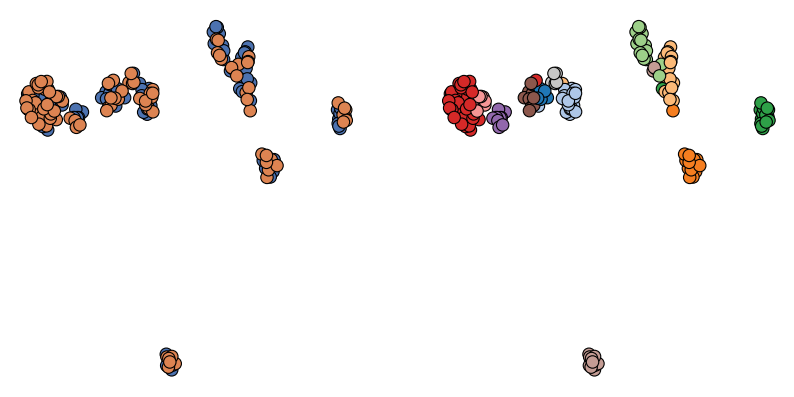

In [294]:
fig = plt.figure(figsize=[10, 5])

order = np.random.choice(comb_ad.obs_names, comb_ad.shape[0], False)

ax = fig.add_subplot(121)
ax.scatter(comb_ad[order].obsm['X_umap'][:, 0], 
            comb_ad[order].obsm['X_umap'][:, 1], 
            edgecolors='black',
            s=80, color=pd.Series(comb_ad.uns['datatype_colors'], index=comb_ad[order].obs['datatype'].values.categories)[comb_ad.obs['datatype']]
           )
ax = plt.gca()
ax.set_axis_off()

ax = fig.add_subplot(122)
ax.scatter(comb_ad[order].obsm['X_umap'][:, 0], 
            comb_ad[order].obsm['X_umap'][:, 1], 
            edgecolors='black',
            s=80, color=ct_colors[comb_ad[order].obs['celltype']]
           )
ax = plt.gca()
ax.set_axis_off()

plt.savefig(plot_prefix + f'pbmc_rna_projected_on_atac.png', dpi=150, bbox_inches='tight')

In [ ]:
    # genes = 'CD8A', 'CD14'
    # celltypes = ['CD8 T cells Naive', 'CD14 Monocytes']


    # genes = ['NKG7', 'CD8A']
    # celltypes = ['CD8 T cells Mem', 'NK cells']


    # genes = ['ITGAM', 'CLEC4C'] # CD11b, BDCA-2
    # celltypes = ['pDC', 'Dendritic']

    # cells = rna_ad.obs_names[rna_ad.obs['celltype2'].isin(celltypes)]
    # sc_df = pd.DataFrame(rna_ad[cells][:, genes].X.todense(), 
    #             index=cells, columns=genes)

    # cells = rna_meta_ad.obs_names[rna_meta_ad.obs['celltype2'].isin(celltypes)]
    # meta_df = pd.DataFrame(rna_meta_ad[cells][:, genes].X.todense(), 
    #             index=cells, columns=genes)

# SCRATCH